# Figures for https://www.nature.com/articles/s41588-023-01574-w

## Libraries and helper functions 

In [1]:
# Plotting and math libararies
import h5py
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

import pydove as dv
import scipy
from scipy.stats import rankdata, spearmanr

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

blue = sns.color_palette("colorblind")[0]
orange = sns.color_palette("colorblind")[1]
turquoise = sns.color_palette("colorblind")[2]
bloodorange = sns.color_palette("colorblind")[3]
turquoise2 = np.array(turquoise)-0.00784313725490196

In [2]:
# TODO: add subheaders and organize plots
# TODO: remove comments
# TODO: make sure all data is on github
# TODO: Push


In [3]:
# Get repo directory (for data paths)
pre = "/".join(os.getcwd().split("/")[:-1])+"/"
print(pre)

/global/home/users/rkchung/personalized-expression-benchmark/


In [4]:
# Paths to expression
GEUVADIS_PATH = pre+"predictions/geuvadis_peer_normalized.csv"
ENFORMER_PREDS_PATH = pre+"predictions/enformer_sample_preds.csv"
BASENJI_PREDS_PATH = pre+"predictions/basenji2_sample_preds.csv"
XPRESSO_PREDS_PATH = pre+"predictions/xpresso_sample_preds.csv"
EXPECTO_PREDS_PATH = pre+"predictions/expecto_sample_preds.csv"
PREDIXCAN_PREDS_PATH = pre+"predictions/predixcan_197KB_sample_preds.csv"

path_mapping = {"Enformer":ENFORMER_PREDS_PATH, "Basenji2":BASENJI_PREDS_PATH, 
                "Xpresso": XPRESSO_PREDS_PATH, "ExPecto": EXPECTO_PREDS_PATH}

In [5]:
eval_genes = pd.read_csv(pre+"data/gene_list.csv", 
                         names=["gene_id", "Chr", "Position", "name", "Strand"])
eval_genes.name = eval_genes.name.fillna(eval_genes.gene_id)
eval_genes.name = eval_genes.name.apply(lambda n: n.lower() if isinstance(n, str) else n)
eval_genes

gene_id  Chr   Position             name Strand
0     ENSG00000000457    1  169863408            scyl3      -
1     ENSG00000001630    7   91772266          cyp51a1      -
2     ENSG00000002549    4   17578815             lap3      +
3     ENSG00000002745    7  120965421            wnt16      +
4     ENSG00000003056   12    9102551             m6pr      -
...               ...  ...        ...              ...    ...
3254  ENSG00000262879   17   45177689       ac005670.3      -
3255  ENSG00000262951   17   54946308  ensg00000262951      +
3256  ENSG00000262992   17   18932637  ensg00000262992      +
3257  ENSG00000263004   17   55162385       ac007114.1      -
3258  ENSG00000263280   16    2917619       ac003965.1      -

[3259 rows x 5 columns]

In [6]:
# Helper math functions
def compute_spearman_with_nans(X, Y):
    X_subset = [x for i, x in enumerate(X) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    Y_subset = [y for i, y in enumerate(Y) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    return spearmanr(X_subset, Y_subset)[0]

def compute_pearson_with_nans(X, Y):
    X_subset = [x for i, x in enumerate(X) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    Y_subset = [y for i, y in enumerate(Y) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    return scipy.stats.pearsonr(X_subset, Y_subset)

def log_transform(arr, pseudocount=1e-3):
    return np.log(arr + pseudocount)

In [7]:
def cross_individual_correlations(preds_path: str, absolute=False):
    """
    Given csv of model predictions for all individuals and genes
        produces cross-individual correlation between model predictions
        and true gene expression values    
    """
    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    preds_df = pd.read_csv(preds_path, index_col=0)
    assert geuvadis_df.index.equals(preds_df.index)
    
    unpredicted_genes = set(geuvadis_df.columns) - set(preds_df.columns)
    print(f"There are {len(unpredicted_genes)} unpredicted genes: {unpredicted_genes}")
    
    outdf = []
    for gene in preds_df.columns:
        rho, p = spearmanr(geuvadis_df[gene], preds_df[gene])
        outdf += [[gene, rho, p, preds_df[gene].max()-preds_df[gene].min()]]
    outdf = pd.DataFrame(outdf, columns=["name", "spearman", "pvalue", "predrange"])
    return outdf

# Given csv of model predictions for all individuals and genes
#   produces cross-gene correlation between model predictions
#   and true gene expression values
def cross_gene_correlations(preds_path):
    """
    Given csv of model predictions for all individuals and genes
        produces cross-gene correlation between model predictions
        and true gene expression values    
    """
    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    preds_df = pd.read_csv(preds_path, index_col=0)
    assert geuvadis_df.index.equals(preds_df.index)
    
    unpredicted_genes = set(geuvadis_df.columns) - set(preds_df.columns)
    print(f"There are {len(unpredicted_genes)} unpredicted genes: {unpredicted_genes}")

    geuvadis_df = geuvadis_df.stack().reset_index().rename(
        {"level_0":"samples", "level_1":"gene", 0:"geuvadis"}, axis=1)
    preds_df = preds_df.stack().reset_index().rename(
        {"level_0":"samples", "level_1":"gene", 0:"pred"}, axis=1)
    
    merged = geuvadis_df.merge(preds_df, on=["gene", "samples"])

    crossgene_spearmans = merged.groupby("samples").apply(
        lambda row: compute_spearman_with_nans(list(row["geuvadis"]), list(row["pred"])))
    return crossgene_spearmans

def meta_predictions(ENFORMER_PREDS_PATH, BASENJI_PREDS_PATH, XPRESSO_PREDS_PATH, EXPECTO_PREDS_PATH):
    """
    Produces meta predictor by averaging zscored predictions from 4 predictors
    """
    enformer_preds = pd.read_csv(ENFORMER_PREDS_PATH, index_col=0)
    basenji_preds = pd.read_csv(BASENJI_PREDS_PATH, index_col=0)
    xpresso_preds = pd.read_csv(XPRESSO_PREDS_PATH, index_col=0)
    expecto_preds = pd.read_csv(EXPECTO_PREDS_PATH, index_col=0)
    
    # Standardize all predictions
    enformer_preds = (enformer_preds-enformer_preds.mean())/enformer_preds.std()
    basenji_preds = (basenji_preds-basenji_preds.mean())/basenji_preds.std()
    xpresso_preds = (xpresso_preds-xpresso_preds.mean())/xpresso_preds.std() 
    expecto_preds = (expecto_preds-expecto_preds.mean())/expecto_preds.std()
    
    # Set of overlapping genes
    genes = list(set(enformer_preds.columns)\
                 .intersection(basenji_preds.columns)\
                 .intersection(xpresso_preds.columns)\
                 .intersection(expecto_preds.columns))
    
    # Initalize dataframe
    meta_preds = pd.DataFrame(list(enformer_preds.index), columns=["indiv"])
    meta_preds = meta_preds.set_index("indiv")
    for g in genes:
        meta_preds.loc[enformer_preds.index, g] = \
                        (
                            enformer_preds.loc[enformer_preds.index,g] \
                            + basenji_preds.loc[enformer_preds.index,g]\
                            + xpresso_preds.loc[enformer_preds.index,g]\
                            + expecto_preds.loc[enformer_preds.index,g]
                        )/4
    return meta_preds


In [8]:
def pull_ref_predictions(method_name):
    """
    Returns df of reference predictions for given model with Geuvadis expression
    """
    all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")

    preds_label = r"$log("+method_name+r"_{ref} + 10^{-3})$"
    preds_df = all_ref_preds[["gene", method_name]].rename({method_name: preds_label}, axis=1)

    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    geuv_label = r"$log(Median Expression + 10^{-3}))$"
    geuvadis_df = geuvadis_df.median().T.reset_index().rename(
        {"index":"gene", 0:geuv_label}, axis=1)
    geuvadis_df[geuv_label] = log_transform(geuvadis_df[geuv_label])
    if method_name == "Enformer":
        preds_df[preds_label] = log_transform(preds_df[preds_label])
    if method_name == "Xpresso":
        preds_df[preds_label] = log_transform((10**(preds_df[preds_label])-0.1).clip(lower=0))

    merged = geuvadis_df.merge(preds_df, on=["gene"])
    merged = merged.dropna()
    return merged

In [9]:
def get_rank_dict(df_path: str): #-> dict[str, dict[str, float]]:
    """
    Returns a dictionary mapping a gene to a dictionary mapping a sample name to a rank.
    Smaller ranks indicate lower expression
    """
    ranks_by_gene = {}
    df = pd.read_csv(df_path, index_col=0)
    samples = df.index
    for gene in df.columns:
        values = np.asarray(df[gene])
        if np.all(values == values[0]):
            # If all values are the same, then we can't compute a rank per sample so skip.
            continue
        assert not np.any(np.isnan(values))
        ranks = rankdata(values, method='average')
        ranks_by_gene[gene] = {s: r for s, r in zip(samples, ranks)}
    return ranks_by_gene

In [10]:
def get_zscores(df_path: str): #-> dataframe
    """
    Returns a dataframe of normalized expression/predictions
    """
    zscores_by_gene = {}
    df = pd.read_csv(df_path, index_col=0)
    if "enformer" in df_path:
        df = log_transform(df)
    if "xpresso" in df_path:
        df = log_transform((10**(df)-0.1).clip(lower=0))

    df = df.apply(lambda row: (row-np.mean(row))/np.std(row) if not np.all(np.array(row)==row[-1]) else np.nan)
    return df

In [11]:
def reject_outliers(data, m=2):
    data = data[np.isfinite(data)]
    return data[abs(data - np.nanmean(data)) < (m * np.nanstd(data))]

## Calculate model performance (correlation with Geuvadis expression)

In [12]:
# Load cross-individual correlations for all models
enformer_corrs = cross_individual_correlations(ENFORMER_PREDS_PATH)
basenji_corrs = cross_individual_correlations(BASENJI_PREDS_PATH)
xpresso_corrs = cross_individual_correlations(XPRESSO_PREDS_PATH)
expecto_corrs = cross_individual_correlations(EXPECTO_PREDS_PATH)
predixcan_corrs = cross_individual_correlations(PREDIXCAN_PREDS_PATH)

# Load cross-gene correlations for all models
enformer_crossgene_corrs = cross_gene_correlations(ENFORMER_PREDS_PATH)
basenji_crossgene_corrs = cross_gene_correlations(BASENJI_PREDS_PATH)
xpresso_crossgene_corrs = cross_gene_correlations(XPRESSO_PREDS_PATH)
expecto_crossgene_corrs = cross_gene_correlations(EXPECTO_PREDS_PATH)

corr_mapping = {"Enformer":enformer_corrs, "Basenji2":basenji_corrs, 
                "Xpresso": xpresso_corrs, "ExPecto": expecto_corrs,
                "PrediXcan": predixcan_corrs}

crossgene_corr_mapping = {"Enformer":enformer_crossgene_corrs, "Basenji2":basenji_crossgene_corrs, 
                          "Xpresso": xpresso_crossgene_corrs, "ExPecto": expecto_crossgene_corrs}

There are 0 unpredicted genes: set()


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


There are 0 unpredicted genes: set()
There are 2 unpredicted genes: {'al035071.1', 'ensg00000205233'}
There are 0 unpredicted genes: set()
There are 2 unpredicted genes: {'ensg00000235398', 'ensg00000231360'}
There are 0 unpredicted genes: set()
There are 0 unpredicted genes: set()
There are 2 unpredicted genes: {'al035071.1', 'ensg00000205233'}
There are 0 unpredicted genes: set()


## Overall model performance

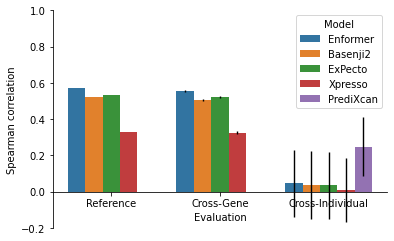

<Figure size 432x288 with 0 Axes>

In [13]:
# Figure 1b
models = ["Enformer", "Basenji2", "ExPecto", "Xpresso", "PrediXcan"]

all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")
allresults = []
for method_name in models:
    if method_name != "PrediXcan":
        merged = pull_ref_predictions(method_name)
        geuv_label, preds_label = merged.columns[-2:]
        ref_spearman = compute_spearman_with_nans(list(merged[geuv_label]), 
                                                  list(merged[preds_label]))
        allresults += [[ref_spearman, 
                        0, 
                        "Reference", 
                        method_name]]

        allresults += [[np.mean(crossgene_corr_mapping[method_name]), 
                        np.std(crossgene_corr_mapping[method_name]), 
                        "Cross-Gene", 
                        method_name]]
        
    allresults += [[np.mean(corr_mapping[method_name]["spearman"]), 
                    np.std(corr_mapping[method_name]["spearman"]), 
                    "Cross-Individual", 
                    method_name]]

allresults = pd.DataFrame(allresults, 
                          columns=["Spearman correlation", 
                                   "std", 
                                   "Evaluation",
                                   "Model"])

ax = sns.barplot(data=allresults, 
                 y="Spearman correlation", 
                 x="Evaluation", 
                 hue="Model"
                )

allresults['Evaluation'] = pd.Categorical(allresults['Evaluation'], allresults['Evaluation'].unique())
allresults['Model'] = pd.Categorical(allresults['Model'], allresults['Model'].unique())
allresults = allresults.sort_values(['Evaluation'])
std = list(allresults["std"])
std.insert(4, 0)
std.insert(9, 0)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

coords = pd.DataFrame(np.array([x_coords, y_coords]).T, columns=["x", "y"])
coords = coords.sort_values("x").fillna(0)
ax.errorbar(x=list(coords["x"]), y=list(coords["y"]), yerr=std, fmt="none", c="k", elinewidth=1.4)
plt.ylim(-0.2, 1)
ax.spines['bottom'].set_position("zero")

plt.savefig("figs/allModelEvaluation.pdf", format="pdf")
plt.show()
plt.clf()

## Cross-individual performance

In [14]:
def plot_model_histogram(
    corrs,
    modelname,
    filename,
    absolute=False
):    
    fig, ax = plt.subplots(dpi=200)
    if not absolute:
        corrs = list(corrs["spearman"])
    else:
        corrs = list(corrs["spearman"].abs())

    sns.histplot(corrs, color="green", ax=ax)
    xlabel = "|Spearman R|" if absolute else "Spearman R"
    ax.set(
        xlabel=xlabel, 
        title=f"{modelname} vs Geuvadis {xlabel} across individuals\n mean={np.nanmean(corrs):.4f} std={np.nanstd(corrs):.4f}"
    )
    plt.savefig(f"figs/{filename}", format="pdf", bbox_inches="tight")
    plt.show()

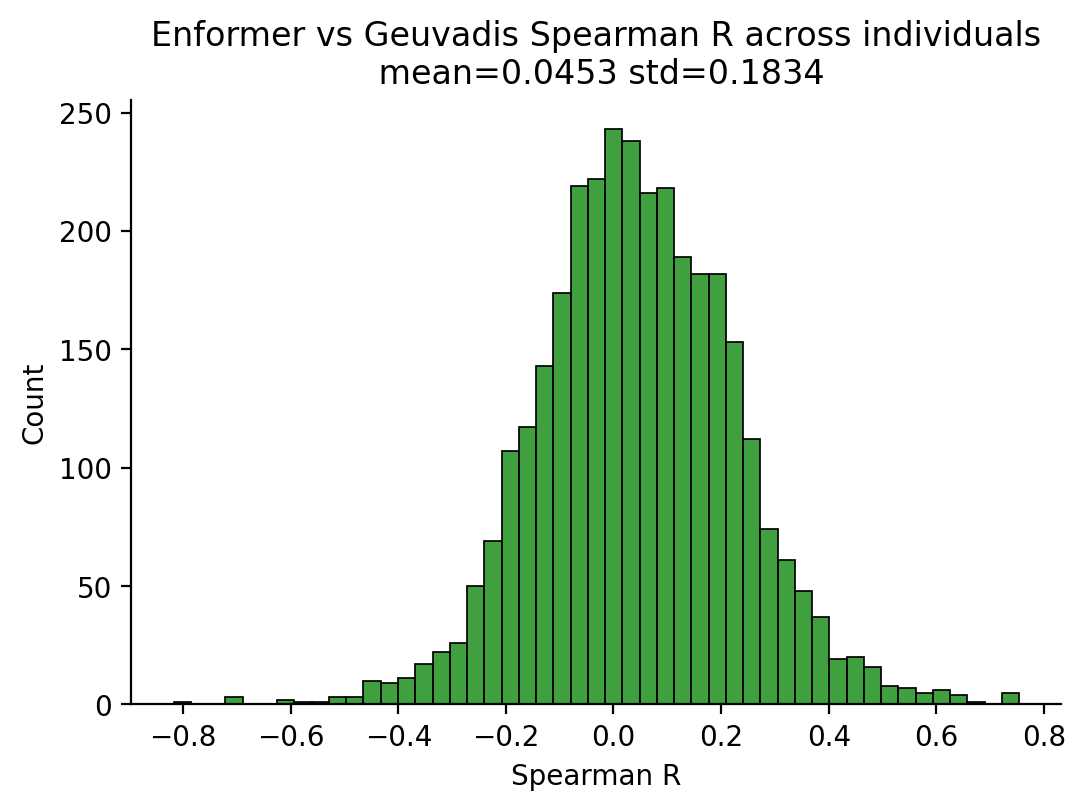

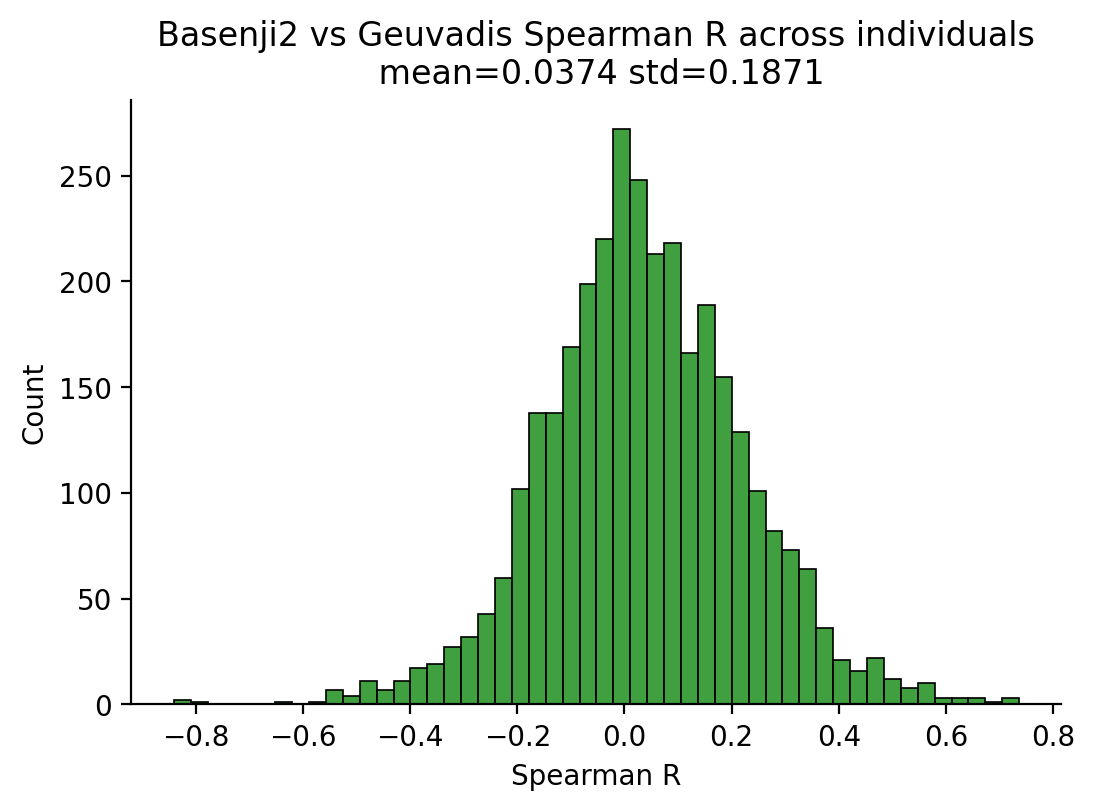

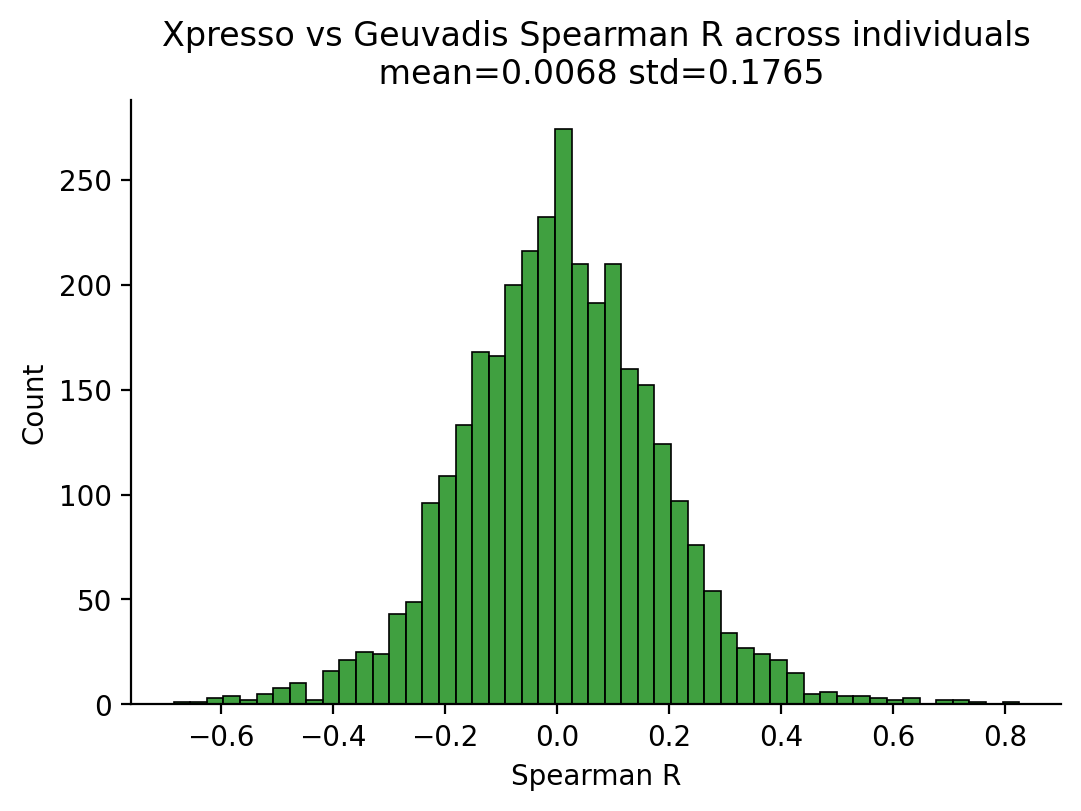

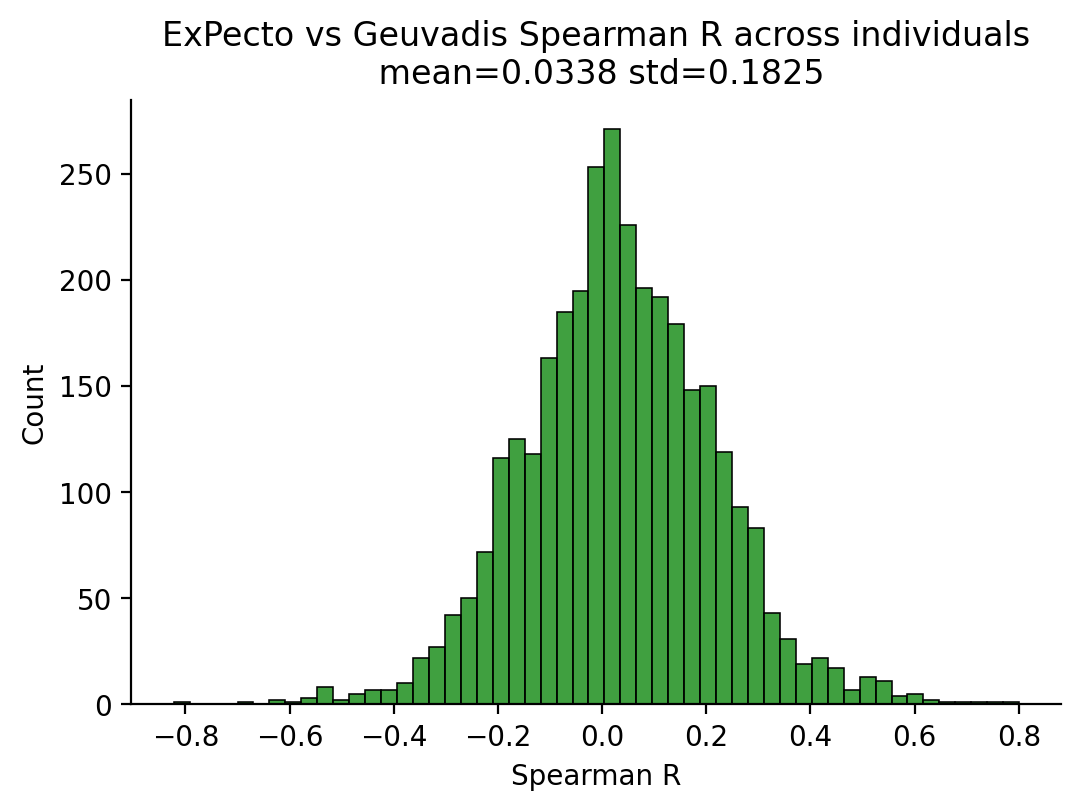

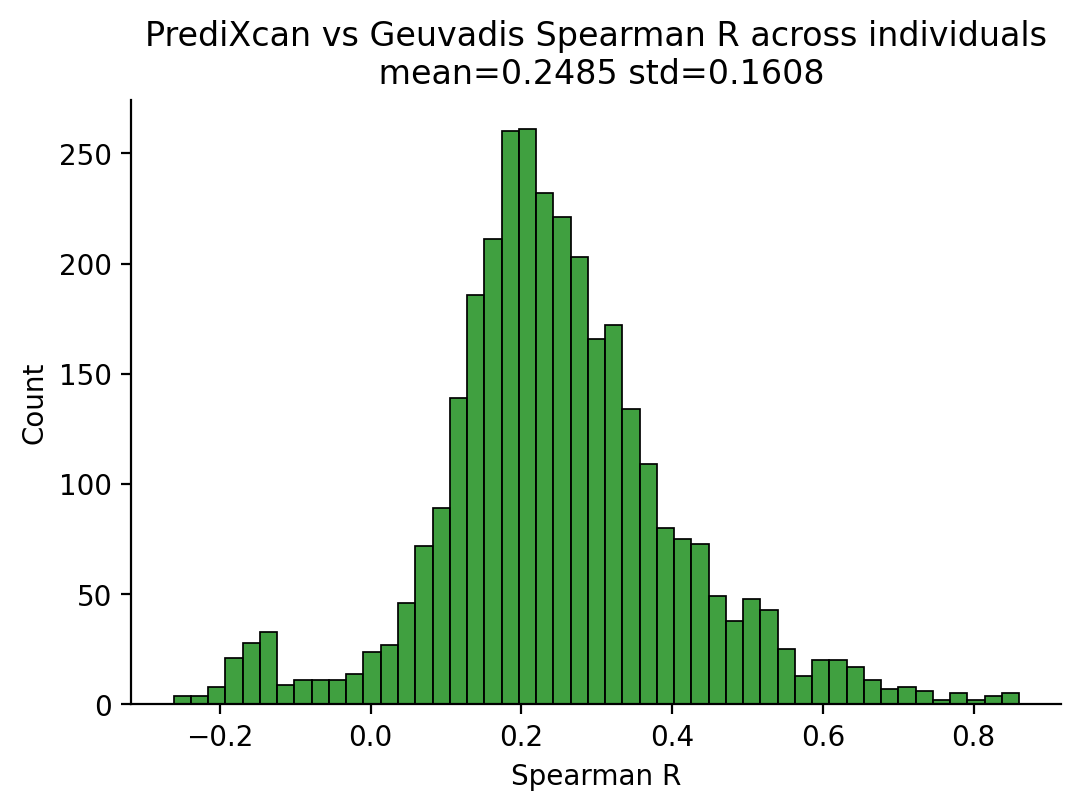

In [15]:
#  Extended Data Fig 3
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto", "PrediXcan"]

for method_name in models:
    plot_model_histogram(corr_mapping[method_name], 
                         method_name,
                         method_name.lower()+"spearman.pdf")

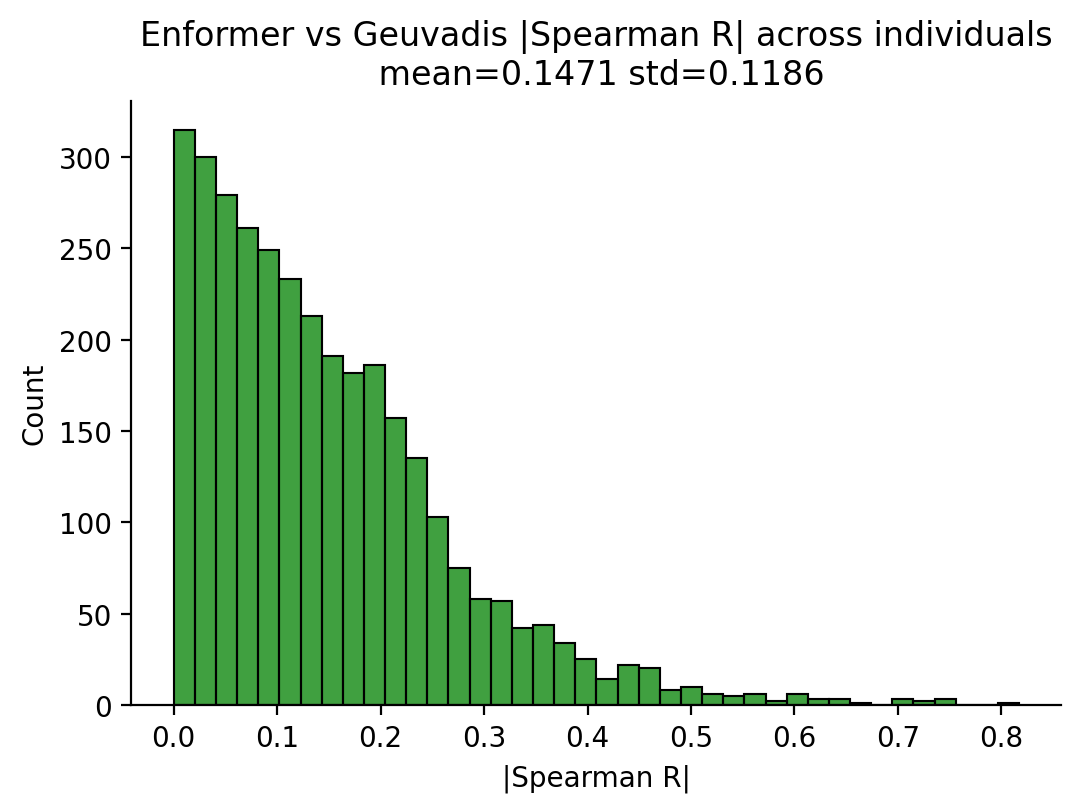

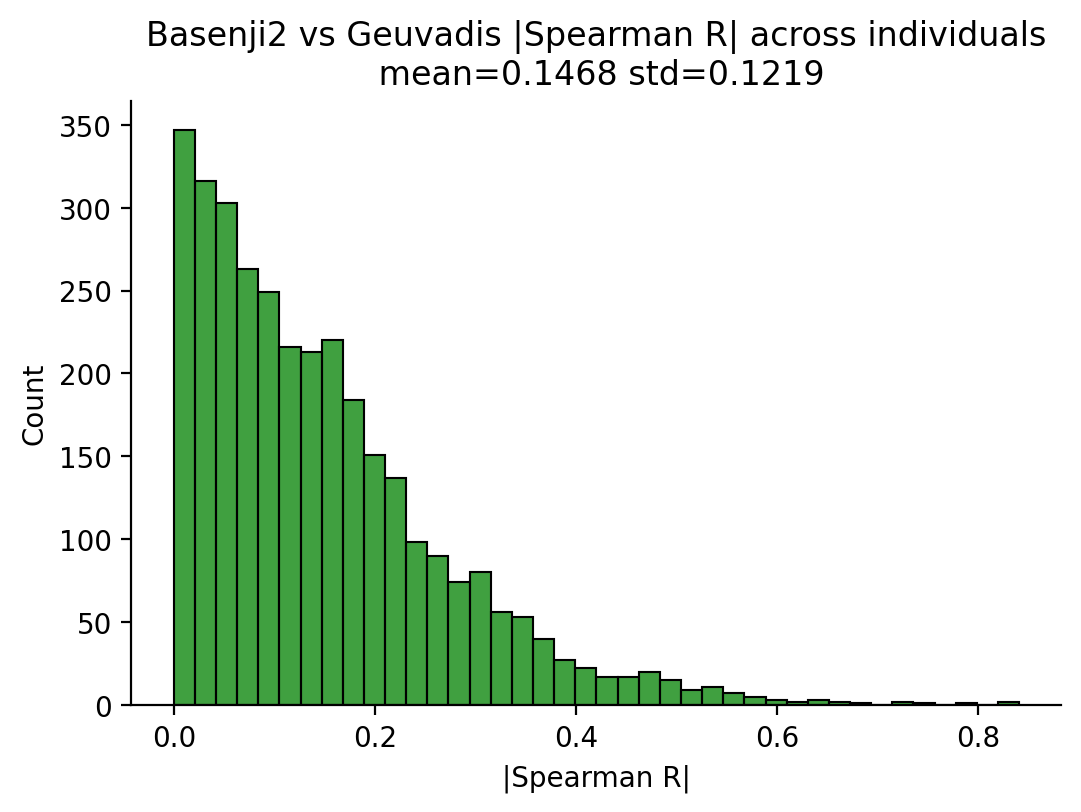

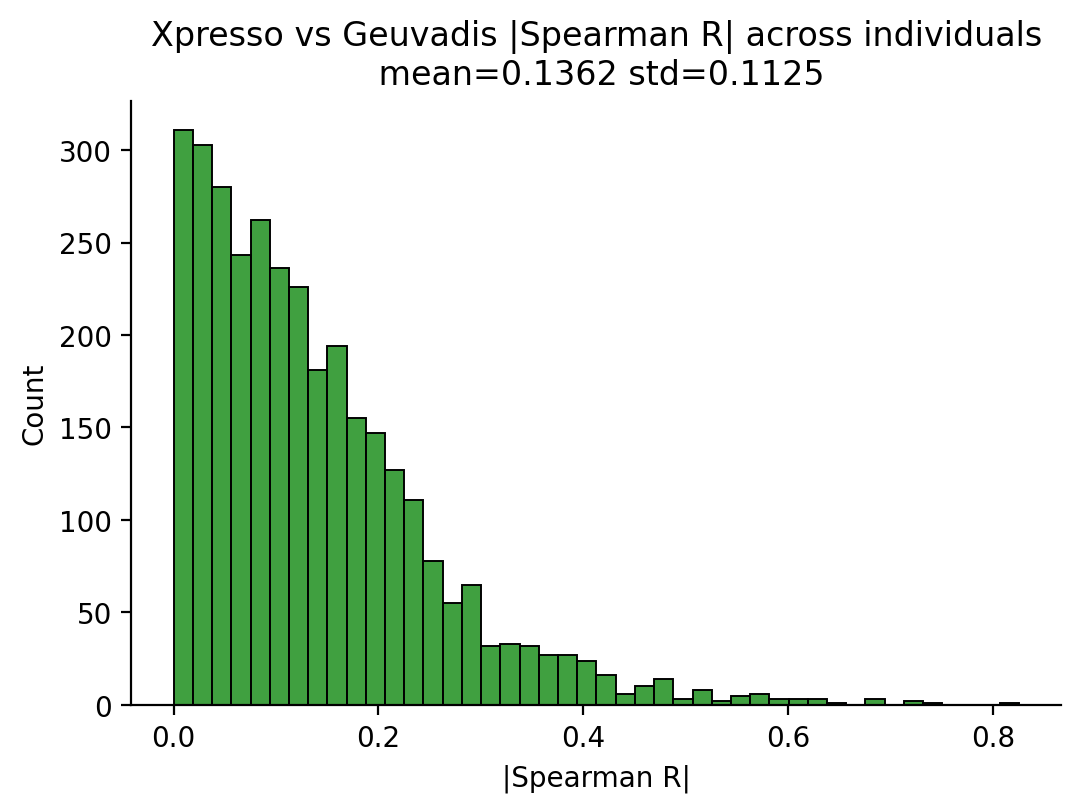

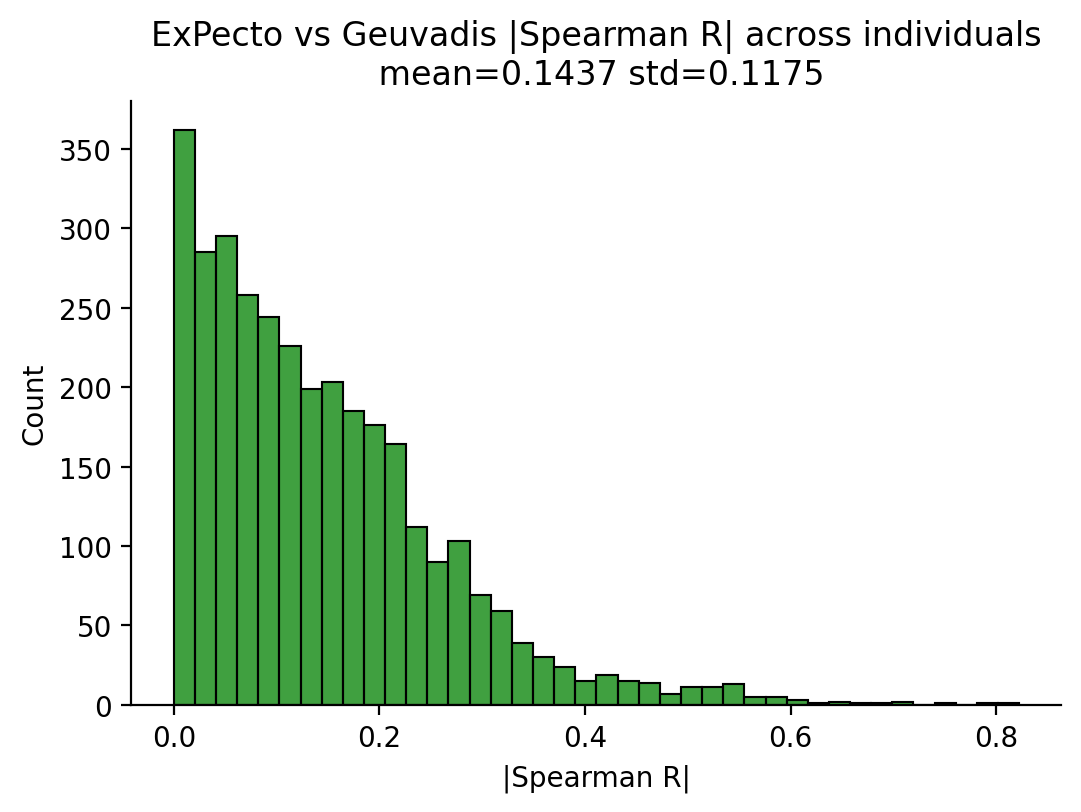

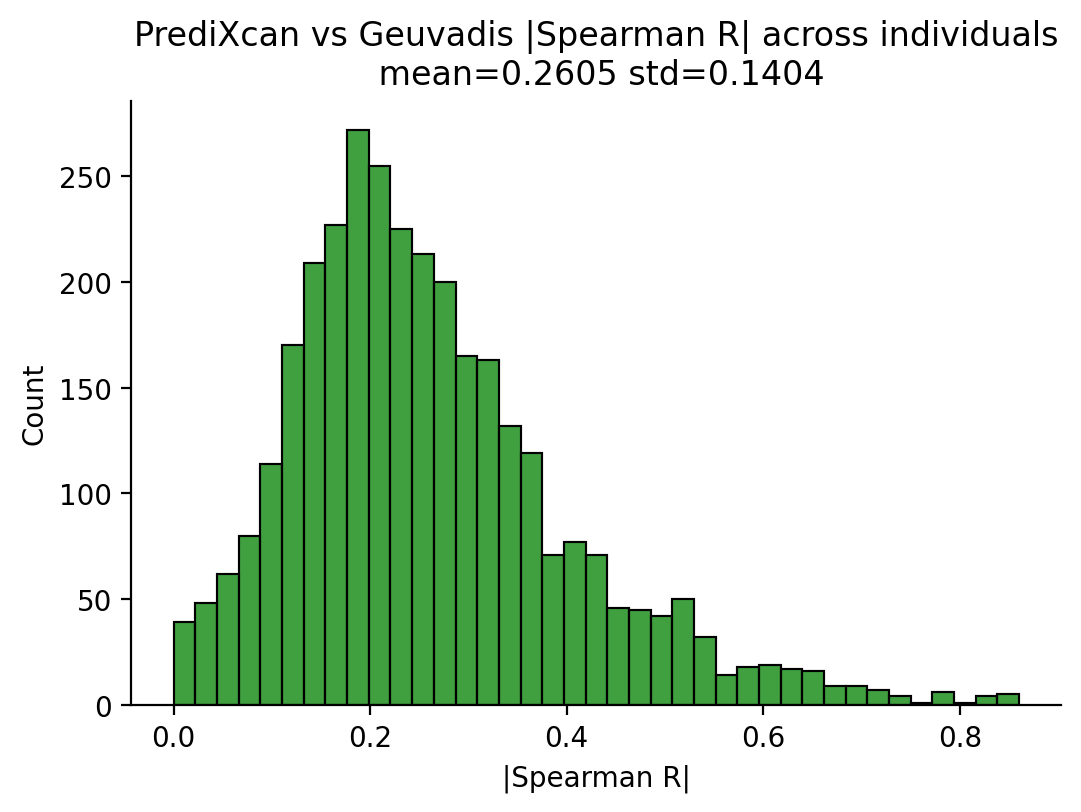

In [16]:
#  Supplementary Fig 1
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto", "PrediXcan"]

for method_name in models:
    plot_model_histogram(corr_mapping[method_name], 
                         method_name, 
                         method_name.lower()+"absspearman.pdf", 
                         absolute=True)

# Cross-gene performance

Enformer


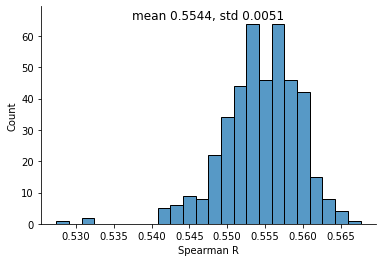

Basenji2


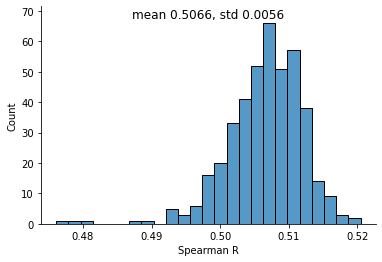

Xpresso


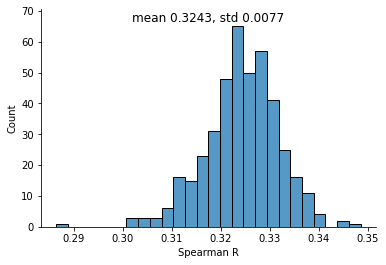

ExPecto


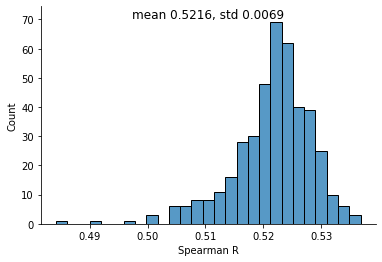

<Figure size 432x288 with 0 Axes>

In [17]:
# Extended Data Fig 2

# Plot cross gene performance
def plot_cross_gene_correlations(corrs, pdf=""):
    ax = plt.subplot(111)
    sns.histplot(data=corrs, ax=ax)
    plt.xlabel("Spearman R")
    
    text_top = np.max([p.get_height() for p in ax.patches])+1.5
    text_middle = 0.5*(np.max(corrs)-np.min(corrs))+np.min(corrs)
    plt.text(text_middle, text_top, 
             f"mean {np.mean(list(corrs)):.4f}, std {np.std(list(corrs)):.4f}", 
             ha="center", fontsize=12)

    plt.ylim(0,text_top+4)

    
    if pdf != "":
        plt.savefig(f"figs/{pdf}", format="pdf")
        
    plt.show()
    plt.clf()

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]
for method_name in models:
    print(method_name)
    plot_cross_gene_correlations(crossgene_corr_mapping[method_name], 
                                 pdf=method_name.lower()+"CrossGeneSpearman.pdf")

# Ensemble model performances

In [18]:
## Average prediction rank across all models
geuvadis_ranks = get_rank_dict(GEUVADIS_PATH)
enformer_ranks = get_rank_dict(ENFORMER_PREDS_PATH)
basenji_ranks = get_rank_dict(BASENJI_PREDS_PATH)
xpresso_ranks = get_rank_dict(XPRESSO_PREDS_PATH)
expecto_ranks = get_rank_dict(EXPECTO_PREDS_PATH)

plt.rcParams['figure.figsize'] = [6.4, 4.8]


In [19]:
def plot_ensemble_model_histogram(
    geuvadis_ranks,
    enformer_ranks,
    basenji_ranks,
    xpresso_ranks,
    expecto_ranks
):
    method_ranks_l = [enformer_ranks, basenji_ranks, xpresso_ranks, expecto_ranks]
    
    # First, we need to compute correlations between the ranks averaged over all methods and the Geuvadis ranks
    corrs_by_gene = {}
    shared_genes = set(geuvadis_ranks.keys()) & set.union(*[set(m.keys()) for m in method_ranks_l])
    
    for gene in shared_genes:
        samples = geuvadis_ranks[gene].keys()
        obs_ranks = np.asarray([geuvadis_ranks[gene][s] for s in samples])
            
        pred_ranks_per_method = []
        for method_ranks in method_ranks_l:
            if gene not in method_ranks:
                continue
            pred_ranks = [method_ranks[gene][s] for s in samples]
            pred_ranks_per_method.append(pred_ranks)
            
        average_pred_ranks = np.mean(pred_ranks_per_method, axis=0)
        assert average_pred_ranks.shape == obs_ranks.shape
        
        corrs_by_gene[gene] = spearmanr(obs_ranks, average_pred_ranks)[0]
    
    corrs_l = list(corrs_by_gene.values())
    
    fig, ax = plt.subplots(dpi=100)
    sns.histplot(corrs_l, ax=ax, color="green")
    ax.set(
        xlabel="Cross-individual correlation of rank averaged ensemble model", 
        title=f"mean={np.mean(corrs_l):.3}"
    )
    plt.savefig("figs/rankaveragedmodelcorrelation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

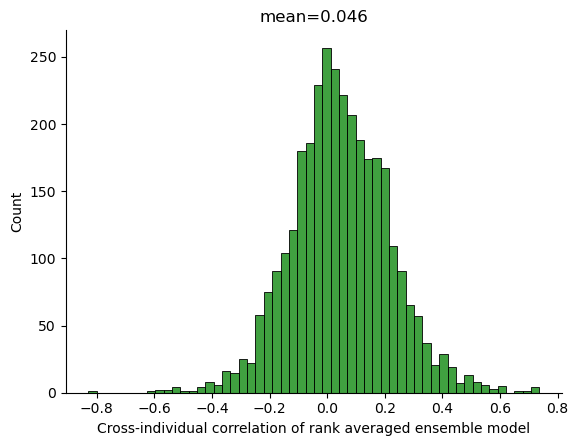

In [20]:
#Supplementary Fig. 2a
plot_ensemble_model_histogram(
    geuvadis_ranks,
    enformer_ranks,
    basenji_ranks,
    xpresso_ranks,
    expecto_ranks
)

In [21]:
def plot_max_model_histogram(
    enformer_corrs,
    basenji_corrs,
    xpresso_corrs,
    expecto_corrs
):
    method_corrs_l = [enformer_corrs, basenji_corrs, xpresso_corrs, expecto_corrs]
    allcorrs = pd.concat(method_corrs_l)
    max_corrs = allcorrs.groupby("name")["spearman"].apply(lambda row: np.nanmax(row))
        
    fig, ax = plt.subplots(dpi=100)
    sns.histplot(data=max_corrs, ax=ax, color="green")
    ax.set(
        xlabel="Maximum cross-individual correlation across all 4 models", 
        title=f"Mean={np.mean(max_corrs):.3f}"
    )
    plt.savefig("figs/maxmodelcorrelation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

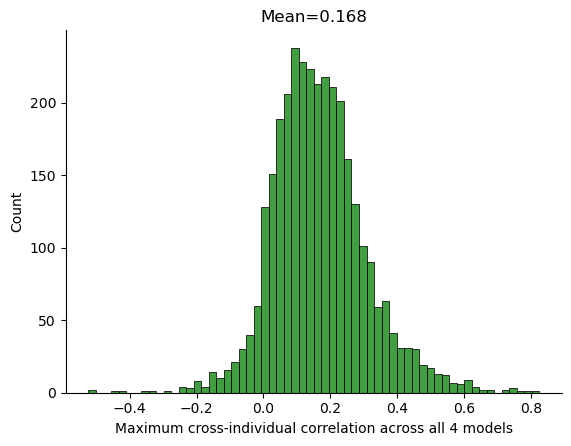

In [22]:
#Supplementary Fig. 2c
plot_max_model_histogram(
    enformer_corrs,
    basenji_corrs,
    xpresso_corrs,
    expecto_corrs
)

In [23]:
geuvadis_zscore = get_zscores(GEUVADIS_PATH)
enformer_zscore = get_zscores(ENFORMER_PREDS_PATH)
basenji_zscore = get_zscores(BASENJI_PREDS_PATH)
xpresso_zscore = get_zscores(XPRESSO_PREDS_PATH)
expecto_zscore = get_zscores(EXPECTO_PREDS_PATH)

In [24]:
def plot_zscore_ensemble_model_histogram(
    geuvadis_zscore,
    enformer_zscore,
    basenji_zscore,
    xpresso_zscore,
    expecto_zscore
):
    method_zscores_l = [enformer_zscore, basenji_zscore, xpresso_zscore, expecto_zscore]
    
    # First, we need to compute correlations between the zscores averaged over all methods and the Geuvaids ranks
    allzscores = pd.concat(method_zscores_l)
    allzscores = allzscores.reset_index().groupby(["index"]).agg(np.nanmean)

    geuvadis_zscore = geuvadis_zscore.stack().reset_index().rename(
        {"level_0":"samples", "level_1":"gene", 0:"geuvadis"}, axis=1)
    allzscores = allzscores.stack().reset_index().rename(
        {"index":"samples", "level_1":"gene", 0:"pred"}, axis=1)

    merged = geuvadis_zscore.merge(allzscores, on=["gene", "samples"])
    spearmans = merged.groupby("gene").apply(
        lambda row: compute_spearman_with_nans(list(row["geuvadis"]), list(row["pred"])))    
    
    fig, ax = plt.subplots(dpi=100)
    sns.histplot(spearmans, ax=ax, color="green")
    ax.set(
        xlabel="Cross-individual correlation of expression averaged ensemble model", 
        title=f"mean={np.mean(spearmans):.3}"
    )
    plt.savefig("figs/expressionaveragedmodelcorrelation.pdf", format="pdf", bbox_inches="tight")

    plt.show()

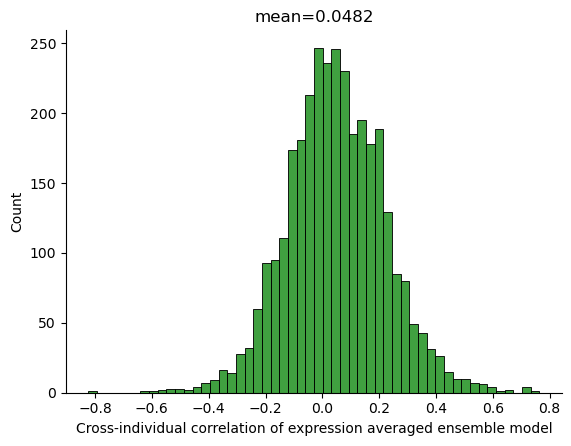

In [25]:
#Supplementary Fig. 2b
plot_zscore_ensemble_model_histogram(
    geuvadis_zscore,
    enformer_zscore,
    basenji_zscore,
    xpresso_zscore,
    expecto_zscore
)

## Model reference prediction performance

In [26]:
# Plot model reference predictions vs median Geuvadis gene expression (per gene)
def plot_ref_predictions_vs_geuvadis(method_name, label="", pdf=""):
    merged = pull_ref_predictions(method_name)
    geuv_label, preds_label = merged.columns[-2:]

    ax = plt.subplot(111)
    sns.scatterplot(data=merged, x=geuv_label, y=preds_label, s=10, color="black", ax=ax)
    spearman = compute_spearman_with_nans(list(merged[geuv_label]), list(merged[preds_label]))
    text_top = 0.02*(np.max(merged[preds_label])-np.min(merged[preds_label]))+np.max(merged[preds_label])
    text_middle = 0.5*(np.max(merged[geuv_label])-np.min(merged[geuv_label]))+np.min(merged[geuv_label])

    plt.text(text_middle, text_top, f"Spearman correlation {spearman:.4f}", ha="center", fontsize=12)
    plt.yticks(fontsize=9)
    plt.xticks(fontsize=9)
    
    if pdf != "":
        plt.savefig(f"figs/{pdf}", format="pdf")
        
    plt.show()
    plt.clf()


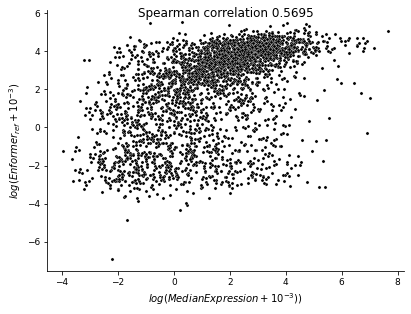

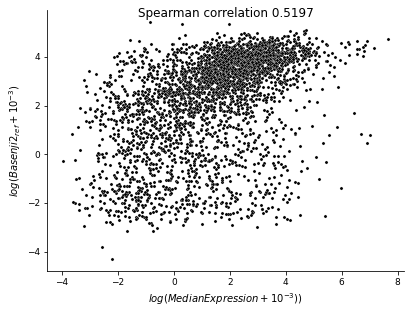

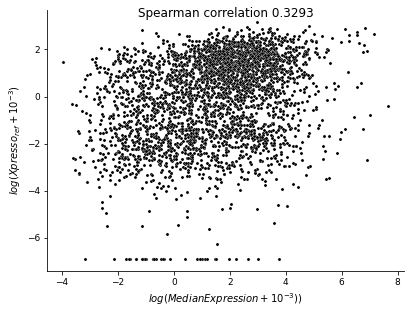

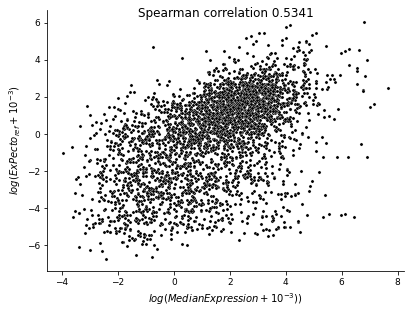

<Figure size 460.8x345.6 with 0 Axes>

In [27]:
# Extended Data Fig 1
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")
for method_name in models:
    plot_ref_predictions_vs_geuvadis(method_name, 
                                     pdf=method_name.lower()+"GeuvadisMedianExpression.pdf")

## Model predictions for example genes

In [28]:
# Plots individual model predictions vs expression data for a few example genes
def plot_preds_vs_geuvadis_gene(preds_path, gene, label="", pdf="", break_axis=False, 
                                ref_pred=None, alt_pred=None, dosage_df=None):
    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    preds_df = pd.read_csv(preds_path, index_col=0)
    assert geuvadis_df.index.equals(preds_df.index)
    
    geuv_label = "Observed expression"
    geuvadis_column = geuvadis_df[gene].to_frame().rename({gene:geuv_label}, axis=1)
    preds_column = preds_df[gene].to_frame().rename({gene:label}, axis=1)
    
    if "Enformer" not in label:
        if "Xpresso" in label:
            preds_column = (10**(preds_column)-0.1).clip(lower=0)
            #preds_column = np.exp(preds_column)-0.001
        else:
            preds_column = np.exp(preds_column)-0.001

    merged = geuvadis_column.join(preds_column)
    if dosage_df is not None:
        merged = merged.join(dosage_df.T.rename({0:"dosage"}, axis=1))
        dosages = ["Dosage: 0", "Dosage: 1", "Dosage: 2"]
        merged["dosage"] = merged["dosage"].apply(lambda d: dosages[d])
    
    if not break_axis:
        fig, ax = plt.subplots(1,1, figsize=(5.5,4))
        sns.scatterplot(data=merged, x=geuv_label, y=label, 
                        s=14, color="black", ax=ax, 
                        hue="dosage" if dosage_df is not None else None,
                        hue_order=["Dosage: 0", "Dosage: 1", "Dosage: 2"], 
                        alpha=0.8, palette="tab10")
        plt.title(gene.upper())
        if ref_pred is not None:
            ax.get_legend().remove()
            plt.plot((np.min(merged[geuv_label]), np.max(merged[geuv_label])), 
                     ((ref_pred, ref_pred)),
                     linestyle="--"
                    )
        if alt_pred is not None:
            plt.plot((np.min(merged[geuv_label]), np.max(merged[geuv_label])),
                     ((alt_pred, alt_pred)),
                     linestyle="--",
                     color="green"
                    )

    else:
        # Broken scatter plot 
        # https://stackoverflow.com/questions/73582438/broken-scatter-graph-with-color-bar
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,
                                      gridspec_kw={
                                           'width_ratios': [4.57, 1]})
        fig.subplots_adjust(wspace=0.05)  # adjust space between axes

        # plot the same data on both axes
        sns.scatterplot(data=merged, x=geuv_label, y=label, s=12, color="black", ax=ax1)
        sns.scatterplot(data=merged, x=geuv_label, y=label, s=12, color="black", ax=ax2)

        # zoom-in / limit the view to different portions of the data
        ax1.set_xlim(-6, 26)  # most of the data
        ax2.set_xlim(33, 40)  # outliers only

        # hide the spines between ax and ax2
        ax1.spines["right"].set_visible(False)
        ax2.spines["left"].set_visible(False)
        ax2.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.tick_params(left = False) 
        
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
                      linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([1], [0], transform=ax1.transAxes, **kwargs)
        ax2.plot([0], [0], transform=ax2.transAxes, **kwargs)

        ax1.set_title(gene.upper())
        ax2.set_xlabel("")
        ax1.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

    if pdf != "":
        plt.savefig(f"figs/{pdf}", format="pdf")
        
    plt.show()
    plt.clf()

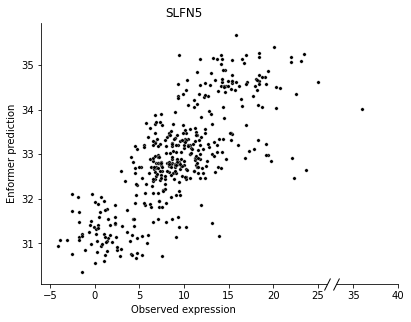

<Figure size 460.8x345.6 with 0 Axes>

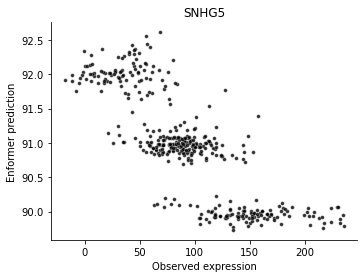

<Figure size 460.8x345.6 with 0 Axes>

In [29]:
# Figure 1D

models = ["Enformer"]
genes = ["slfn5", "snhg5"]
for method_name in models:
    for gene in genes:
        plot_preds_vs_geuvadis_gene(path_mapping[method_name], 
                                    gene,
                                    f"{method_name} prediction",
                                    pdf=f"{method_name.lower()}GeuvadisScatter{gene.upper()}.pdf",
                                    break_axis=(gene=="slfn5"))

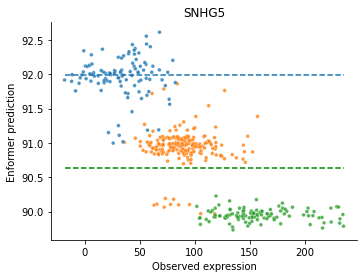

<Figure size 460.8x345.6 with 0 Axes>

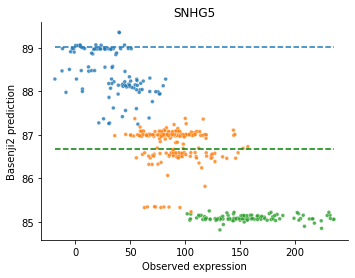

<Figure size 460.8x345.6 with 0 Axes>

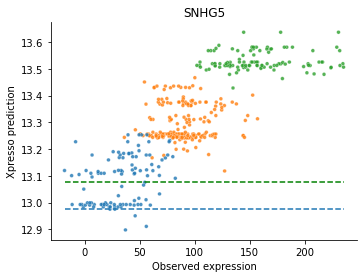

<Figure size 460.8x345.6 with 0 Axes>

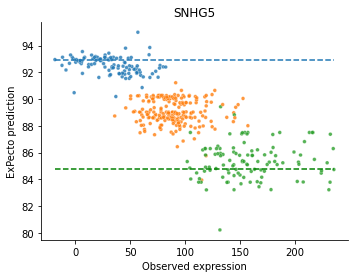

<Figure size 460.8x345.6 with 0 Axes>

In [30]:
# Figure 2A
all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]
genes = ["snhg5"]
eqtldf = pd.read_csv("/clusterfs/nilah/personalized_expression/top30_eqtl_40kb_preds/top30_eqtls_40kb_with_sed.csv")

for method_name in models:
    for gene in genes:
        row = eqtldf[eqtldf["name"]==gene] 
        dosage_df = pd.read_csv("/clusterfs/nilah/connie/enformer/data/dosages.tsv", sep="\t")
        dosage_df["#CHROM"] = dosage_df["#CHROM"].apply(lambda c: c.split("chr")[1]).astype(int)
        dosage_df = row.merge(dosage_df.rename({"#CHROM":"CHR_SNP","POS":"SNPpos"}, axis=1), on=["CHR_SNP", "SNPpos"])
        ref_pred = float(all_ref_preds[all_ref_preds["gene"] == gene][method_name])

        if method_name == "Enformer":
            f = h5py.File("/clusterfs/nilah/personalized_expression/model_predictions/enformer/enformer_eqtl_preds/enformer_eqtl_preds_top_10.h5", "r")
            gs, ref_preds, alt_preds = list(f["genes"]), np.array(f["ref_preds"]), np.array(f["alt_preds"]) 
            gindex = gs.index(bytes(gene, 'utf-8'))
            alt_pred = np.mean(f["alt_preds"][0][896//2-5:896//2+5])
            ref_pred = np.mean(f["ref_preds"][0][896//2-5:896//2+5])
        elif (method_name == "Basenji2") or (method_name == "ExPecto"):
            alt = pd.read_csv("/clusterfs/nilah/personalized_expression/top30_eqtl_40kb_preds/top30_eqtls_40kb_with_sed.csv")
            alt = alt[alt["name"]==gene]
            if method_name == "Basenji2":
                alt_pred = float(alt["basenji_ALT"])
            else:
                alt_pred = float(alt["expecto_ALT"])
                alt_pred = np.exp(alt_pred)-0.001
            ref_pred = np.exp(ref_pred)-0.001
        else:
            xpressoalt = pd.read_csv("/clusterfs/nilah/parth/xpresso_preds/alt_sig_eqtls.GM12878.preds.txt", sep="\t")
            xpressoalt["gene"] = xpressoalt["ID"].apply(lambda i: i.split("|")[2])
            alt_pred = float(xpressoalt[xpressoalt["gene"]==gene]["SCORE"])
            ref_pred = (10**(ref_pred)-0.1)
            alt_pred = (10**(alt_pred)-0.1)

        plot_preds_vs_geuvadis_gene(path_mapping[method_name], 
                                    gene,
                                    f"{method_name} prediction",
                                    pdf=f"{method_name.lower()}GeuvadisScatter{gene.upper()}refalt.pdf",
                                    ref_pred=ref_pred,
                                    alt_pred=alt_pred,
                                    dosage_df=dosage_df
                                   )

## Cross-model performance correlation

In [31]:
# Plotting functions
def plot_scatterplot(
    method_x_corrs, 
    method_y_corrs,
    method_x_name,
    method_y_name,
    s=3,
):
    
    merged_corrs = method_x_corrs.merge(method_y_corrs, on="name")
    
    method_x_corrs_l = merged_corrs["spearman_x"]
    method_y_corrs_l = merged_corrs["spearman_y"]
    spearman = compute_spearman_with_nans(method_x_corrs_l, method_y_corrs_l)
    
    fig, ax = plt.subplots(dpi=300)
    sns.scatterplot(x=method_x_corrs_l, y=method_y_corrs_l, s=s, ax=ax)
    ax.set(
        xlabel=f"cross-individual correlation of {method_x_name} to Geuvadis",
        ylabel=f"cross-individual correlation of {method_y_name} to Geuvadis",
        title=f"Spearman {spearman:.3f}"
    )
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

def plot_contour_ryan(
    method_x_corrs, 
    method_y_corrs, 
    method_x_name,
    method_y_name,
    huedata=None,
    n_bins=36, 
    abs_x=False, # Absolute value of x axis
    abs_y=False, # Absolute value of y axis
    xpad=-40, 
    ypad=-50,
    pdf="", # Save model as pdf with given name
    contour=True, # Contour plot underneath scatter plot
):
    merged_corrs = method_x_corrs.merge(method_y_corrs, on="name")
    if huedata is not None:
        merged_corrs = merged_corrs.merge(huedata[["name", "nonzero weights"]])

    if abs_x:
        merged_corrs["spearman_x"] = np.abs(merged_corrs["spearman_x"])
    if abs_y:
        merged_corrs["spearman_y"] = np.abs(merged_corrs["spearman_y"])
    spearman = compute_spearman_with_nans(list(merged_corrs["spearman_y"]), list(merged_corrs["spearman_x"]))
    analyzing_corrs = merged_corrs[merged_corrs["spearman_x"]>0]
    
    theta = np.linspace(0.0, 2 * np.pi, n_bins, endpoint=False)

    fig = plt.figure()
    axp = fig.add_subplot()
    ax = fig.add_subplot(frameon=False)

    if contour:
        sns.kdeplot(data=merged_corrs, x="spearman_x", y="spearman_y", ax=axp, cmap="Reds", shade=True, bw_adjust=0.8)
        axp.set_xlim(-1,1)
        axp.set_ylim(-1,1)
    
    if not huedata is None:
        merged_corrs["nonzero weights"] = merged_corrs["nonzero weights"].apply(lambda w: np.minimum(40,w))
        plt.plot((0,0), (thresh2, -thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (thresh, 0.8+thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (-thresh, -0.8-thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh,0.8), (0, 0.8-thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh,0.8), (0, -0.8+thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (thresh2, 0.8+thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (-thresh2, -0.8-thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh2,0.8), (0, 0.8-thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh2,0.8), (0, -0.8+thresh2), color="grey", linestyle="--", alpha=0.5)
    sns.scatterplot(data=merged_corrs, x="spearman_x", y="spearman_y", 
                    hue="nonzero weights" if huedata is not None else None, 
                    color="black", s=10, alpha=0.7, ax=ax)
    plt.xlabel("")
    plt.ylabel("")
    if huedata is not None:
        L=plt.legend(title="Average number of nonzero PrediXcan weights")
        L.get_texts()[-1].set_text('>40')
    
    if contour:
        ax.set_frame_on(True)
        ax.spines['bottom'].set_position('zero')
        ax.spines['bottom'].set_bounds(low=-1, high=1)
        ax.spines['left'].set_position('zero')
        ax.spines['left'].set_bounds(low=-1, high=1)
        ax.set_facecolor('none')
        ax.set_yticks([-1,-0.5,0.5,1])
        ax.set_xticks([-1,-0.5,0.5,1])
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        ax.xaxis.set_tick_params(labelsize=22)
        ax.yaxis.set_tick_params(labelsize=22)
    else:
        ax.set_frame_on(True)

    axp.set_xticklabels([])
    axp.set_yticklabels([])
    axp.set_xticks([])
    axp.set_yticks([])
    [v.set_visible(False) for k,v in axp.spines.items()]
    absx = "|" if abs_x else ""
    absy = "|" if abs_y else ""
    if contour:
        axp.set_xlabel(f"{absx}{method_x_name}{absx} cross-individual correlation", size=26, labelpad=16)
        axp.set_ylabel(f"{absy}{method_y_name}{absy} cross-individual correlation", size=26, labelpad=16)
    else:
        ax.set_xlabel(f"{absx}{method_x_name}{absx} cross-individual correlation", size=20)
        ax.set_ylabel(f"{absy}{method_y_name}{absy} cross-individual correlation", size=20, labelpad=8)

    
    if contour:
        plt.text(0, 1.1, f"Spearman {spearman:.3f}", ha="center", fontsize=27)
    if pdf != "":
        plt.savefig(f"figs/{pdf}", format="pdf")
    plt.show()
    return 

Enformer
Basenji2


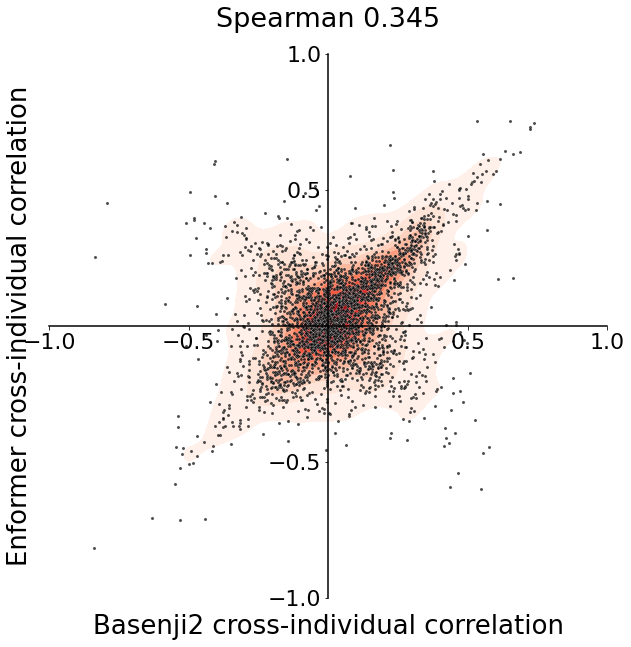

Enformer
Xpresso


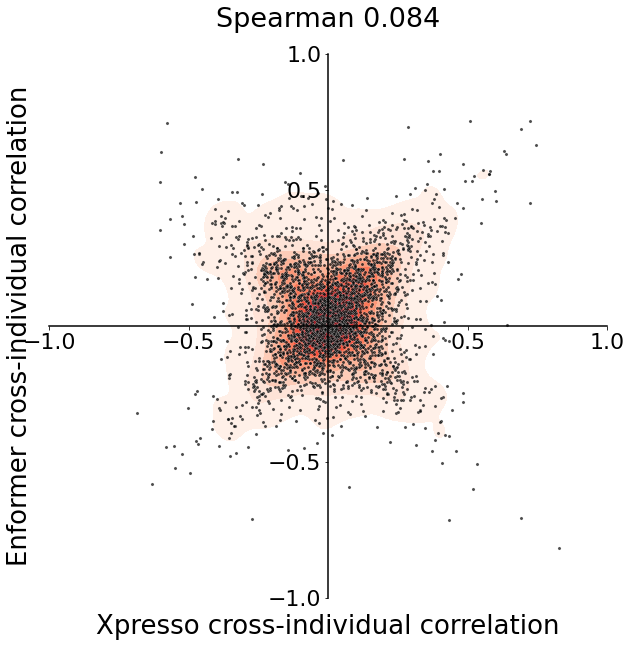

Enformer
ExPecto


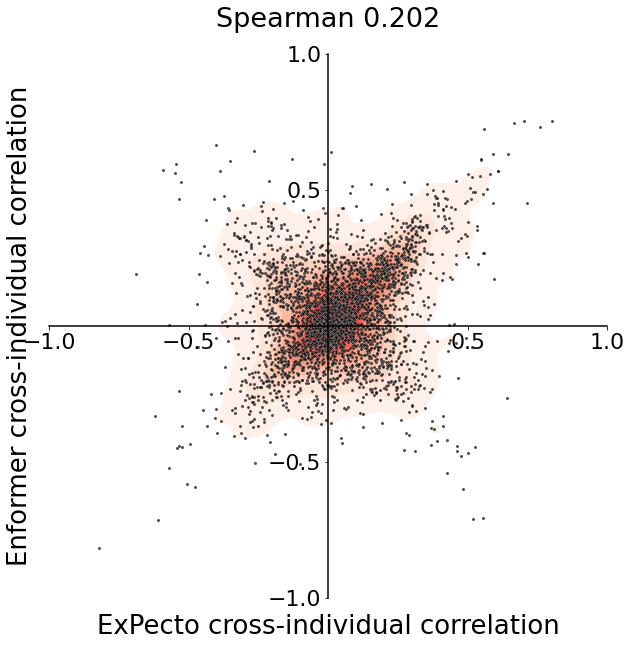

Enformer
PrediXcan


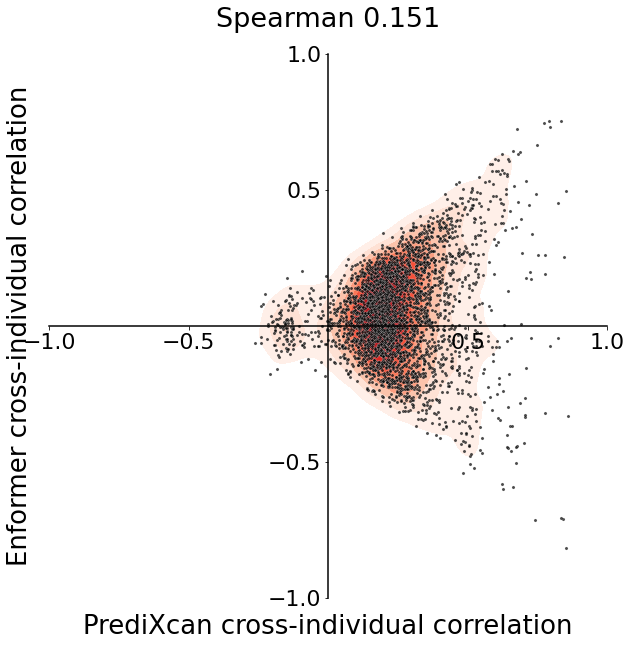

Basenji2
Xpresso


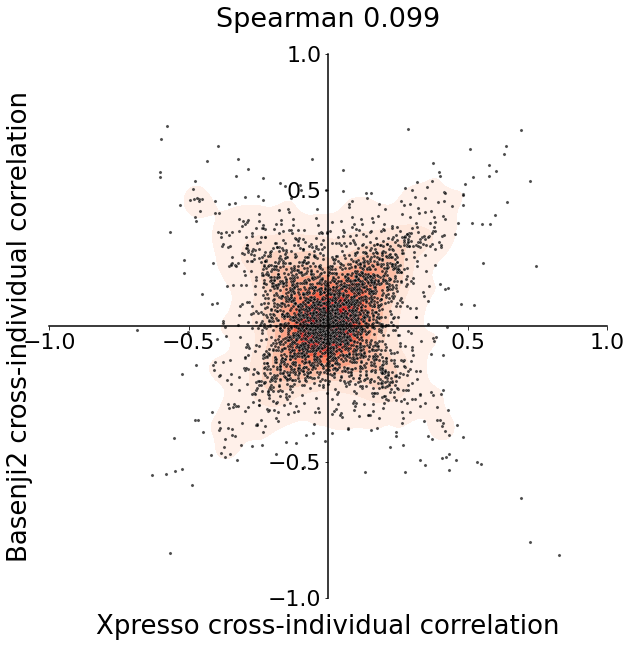

Basenji2
ExPecto


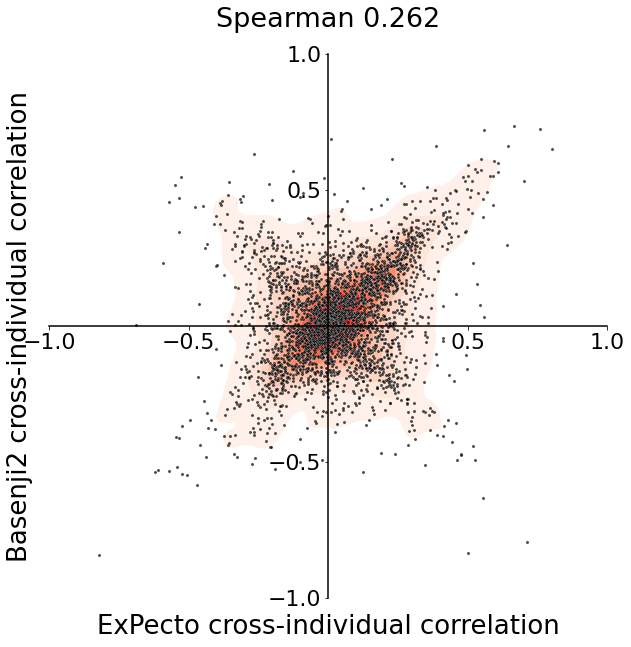

Basenji2
PrediXcan


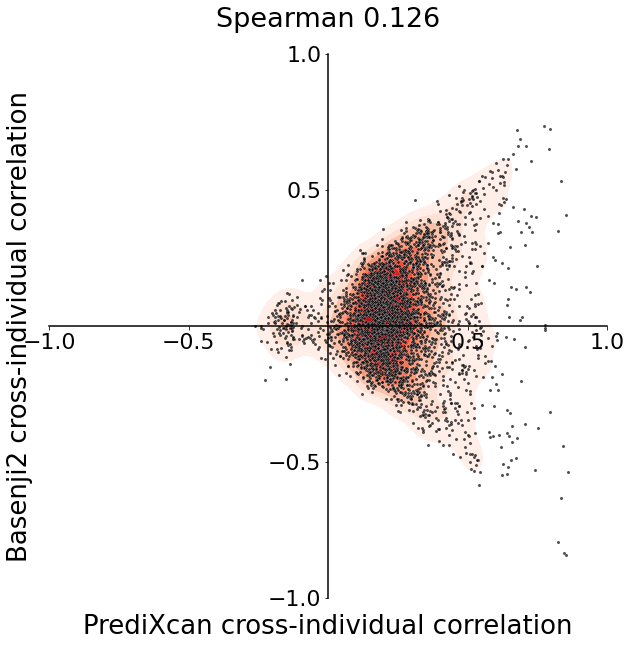

Xpresso
ExPecto


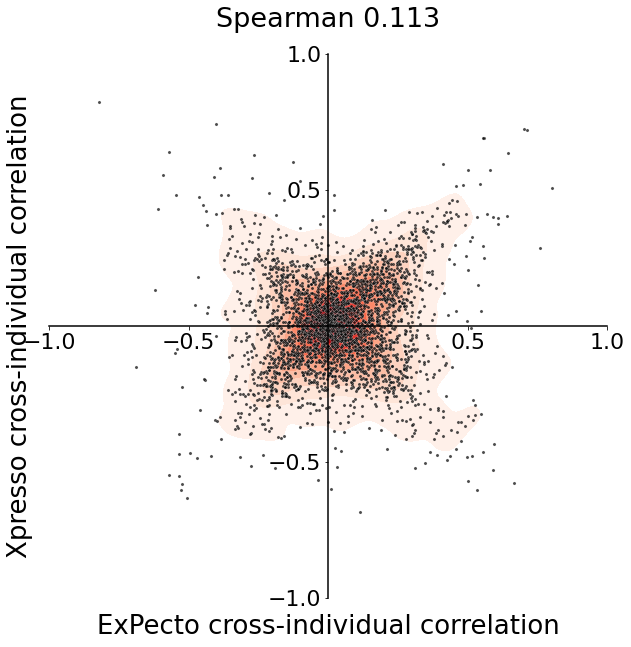

Xpresso
PrediXcan


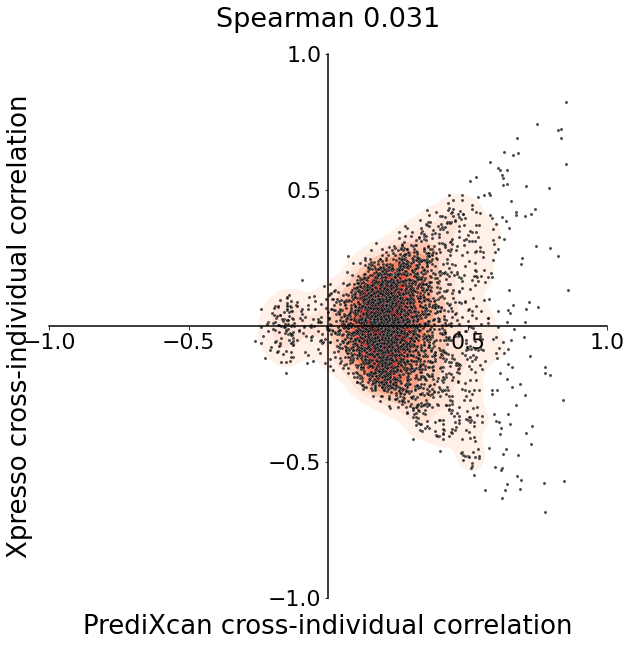

ExPecto
PrediXcan


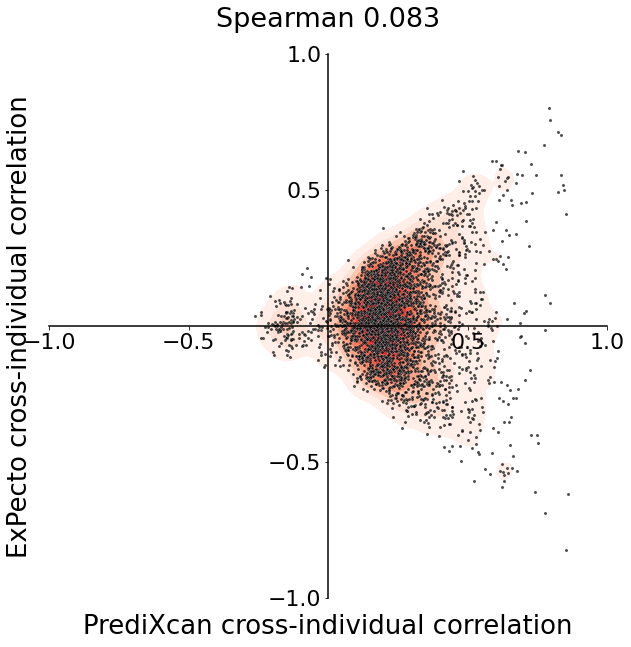

In [32]:
# Figure 2B, Extended Data Fig 4
plt.rcParams['figure.figsize'] = [10, 10]
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto", "PrediXcan"]

for i in range(len(models)):
    for j in range(len(models)-i):
        if j+i+1 < len(models):
            m1 = models[i]
            m2 = models[j+i+1]
            print(m1)
            print(m2)
            _ = plot_contour_ryan(corr_mapping[m2], corr_mapping[m1], m2, m1, 
                                             xpad=-45, ypad=-35, pdf=m1.lower()+m2+"Spearman.pdf")

## Compare model performance to gene features (eQTL power ...)

In [42]:
eqtl_df = pd.read_csv(pre+"data/eqtl_features.csv")

In [34]:
def compare_to_feat(corrs, xlabel=r"$log(distanceToTSS)$", ylabel="", pdf="", feat="median"):
    plt.rcParams['figure.figsize'] = [5, 4]
    
    if feat == "median":
        geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
        genes = list(set(list(corrs.name)).intersection(set(geuvadis_df.columns)))
    else:
        genes = list(set(list(corrs.name)))
        
    if feat in ["distance","minor_allele_freq","rvalue","log10pvalue"]:
        corrs = corrs.merge(eqtl_df, on="name")

    corrs_l = []
    for g in genes:
        corrs_l += [list(corrs[corrs["name"]==g]["spearman"])[0]]
    if feat == "median":
        feat = [log_transform(np.median(geuvadis_df[g])) for g in genes]
    
    fig, ax = plt.subplots(dpi=300)
    res = dv.regplot(y=corrs_l, x=feat, ci = 0,
                     line_kws={"c":"black"}, scatter_kws={"s":2, "c":"black"})
    #nona = merged[merged[y]<0][[x, y]].dropna()
    pearsonout = compute_pearson_with_nans(corrs_l, feat)
    text_left = 0.01*(np.nanmax(feat)-np.nanmin(feat))+np.nanmin(feat)
    text_bottom = 0.01*(np.nanmax(corrs_l)-np.nanmin(corrs_l))+np.nanmin(corrs_l)
    print(text_left)
    print(text_bottom)
    plt.text(text_left, text_bottom, "Pearson %.3f" %  pearsonout[0], color="black")

    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        #title=f"Spearman correlation = {spearman:.3f}"
    )

    if pdf!="":
        plt.savefig(f"figs/{pdf}", format="pdf")
    plt.show()
    
def compare_to_model_coefficient_of_variation(corrs, PREDS_PATH, 
                                              xlabel="", 
                                              ylabel="",
                                              pdf=""):
    plt.rcParams['figure.figsize'] = [5, 4]
    model_df = pd.read_csv(PREDS_PATH, index_col=0)
                
    corrs_l = []
    model_cvs = []

    if "xpresso" in PREDS_PATH:
        model_df = log_transform((10**(model_df)-0.1))
    
    genes = list(set(list(corrs.name)).intersection(set(model_df.columns)))
    for g in genes:
        data = model_df[g]
        cv = np.std(data) / np.mean(data)
        model_cvs.append(cv)
        corrs_l += [list(corrs[corrs["name"]==g]["spearman"])[0]]

    #spearman = compute_spearman_with_nans(corrs_l, model_cvs)
    
    fig, ax = plt.subplots(dpi=300)
    
    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        #title=f"Spearman correlation = {spearman:.3f}",
        #xscale='log'
    )
    model_cvs = np.log(model_cvs)
    res = dv.regplot(y=corrs_l, x=model_cvs, ci = 0,
                     line_kws={"c":"black"}, scatter_kws={"s":2, "c":"black"}, ax=ax)
    #sns.scatterplot(y=corrs_l, x=model_cvs, s=3)
    #nona = model_df[model_df["spearman"]<0][[x, y]].dropna()
    
    pearsonout = compute_pearson_with_nans(corrs_l, model_cvs)
    
    #text_middle = 0.3*(np.min(model_cvs)-np.max(model_cvs))+np.max(model_cvs)
    text_left = 0.05*(np.nanmax(reject_outliers(model_cvs))-\
                      np.nanmin(reject_outliers(model_cvs))
                     )+np.nanmin(reject_outliers(model_cvs))
    text_bottom = 0.01*(np.nanmax(corrs_l)-np.nanmin(corrs_l))+np.nanmin(corrs_l)
    plt.text(text_left, text_bottom, "Pearson %.3f" %  pearsonout[0], ha='center', color="black")
    
    #plt.text(text_middle, 0.75, "Pearson %.3f; P=%.1e" %  pearsonout, ha='center', color="black")
    if pdf!="":
        plt.savefig(f"figs/{pdf}", format="pdf")
    plt.show()

enformerMedianExpression.pdf
-3.829939112485899
-0.8015004418719252


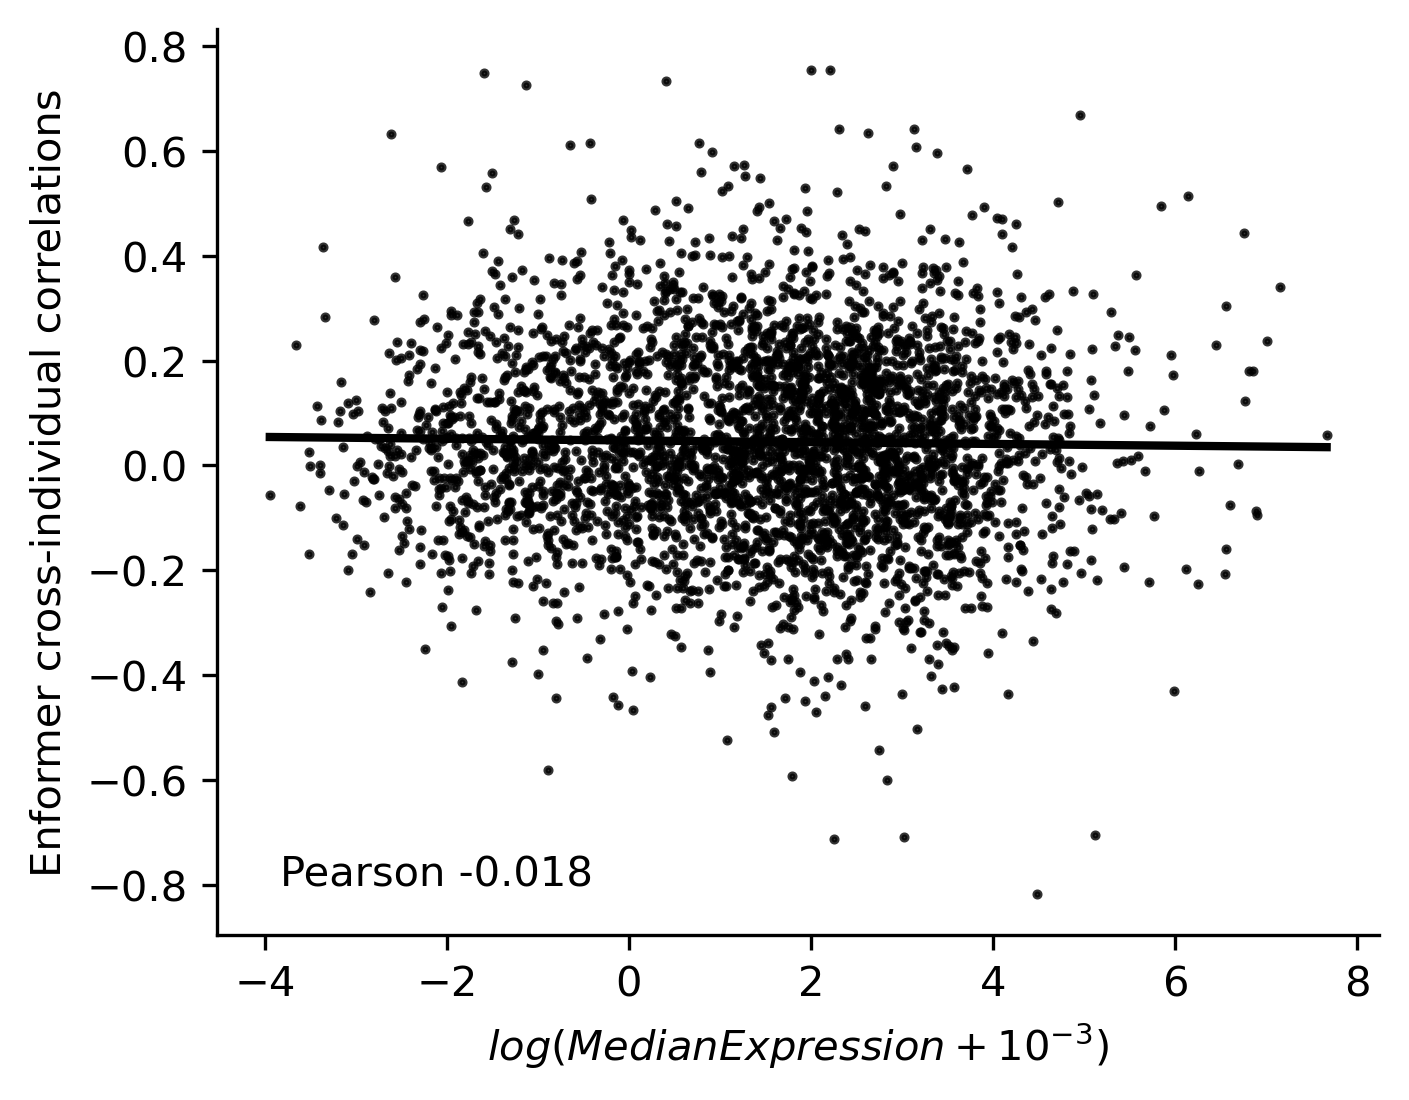

basenji2MedianExpression.pdf
-3.829939112485899
-0.8253033708346778


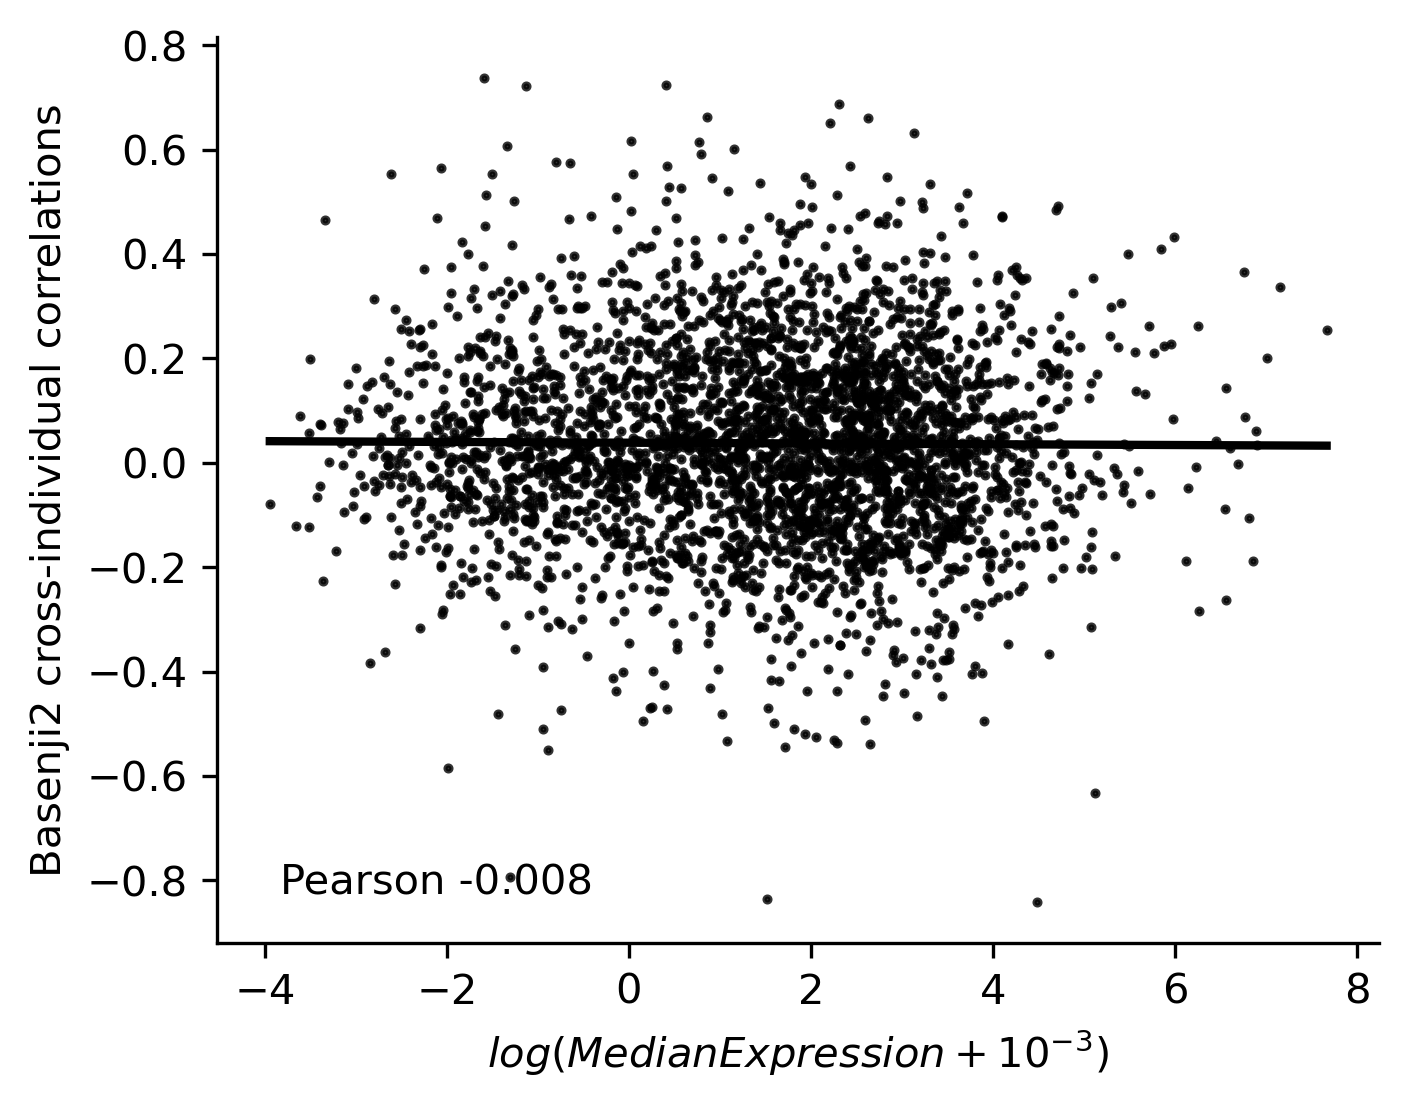

xpressoMedianExpression.pdf
-3.829939112485899
-0.6687226119781547


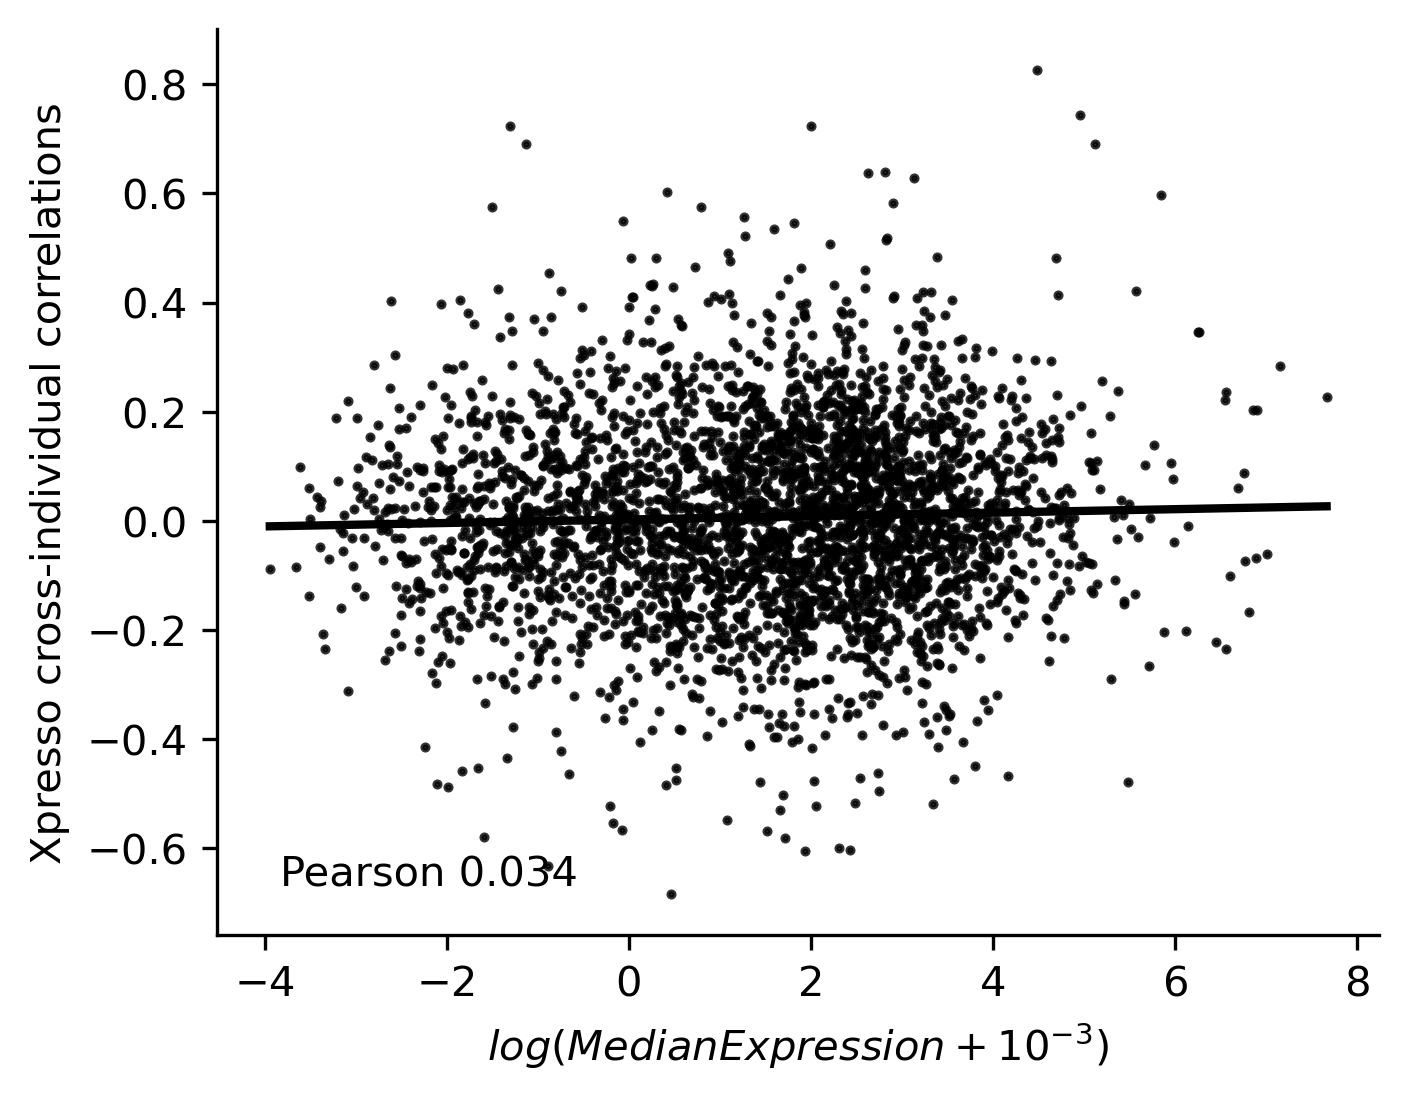

expectoMedianExpression.pdf
-3.829939112485899
-0.8061337797257346


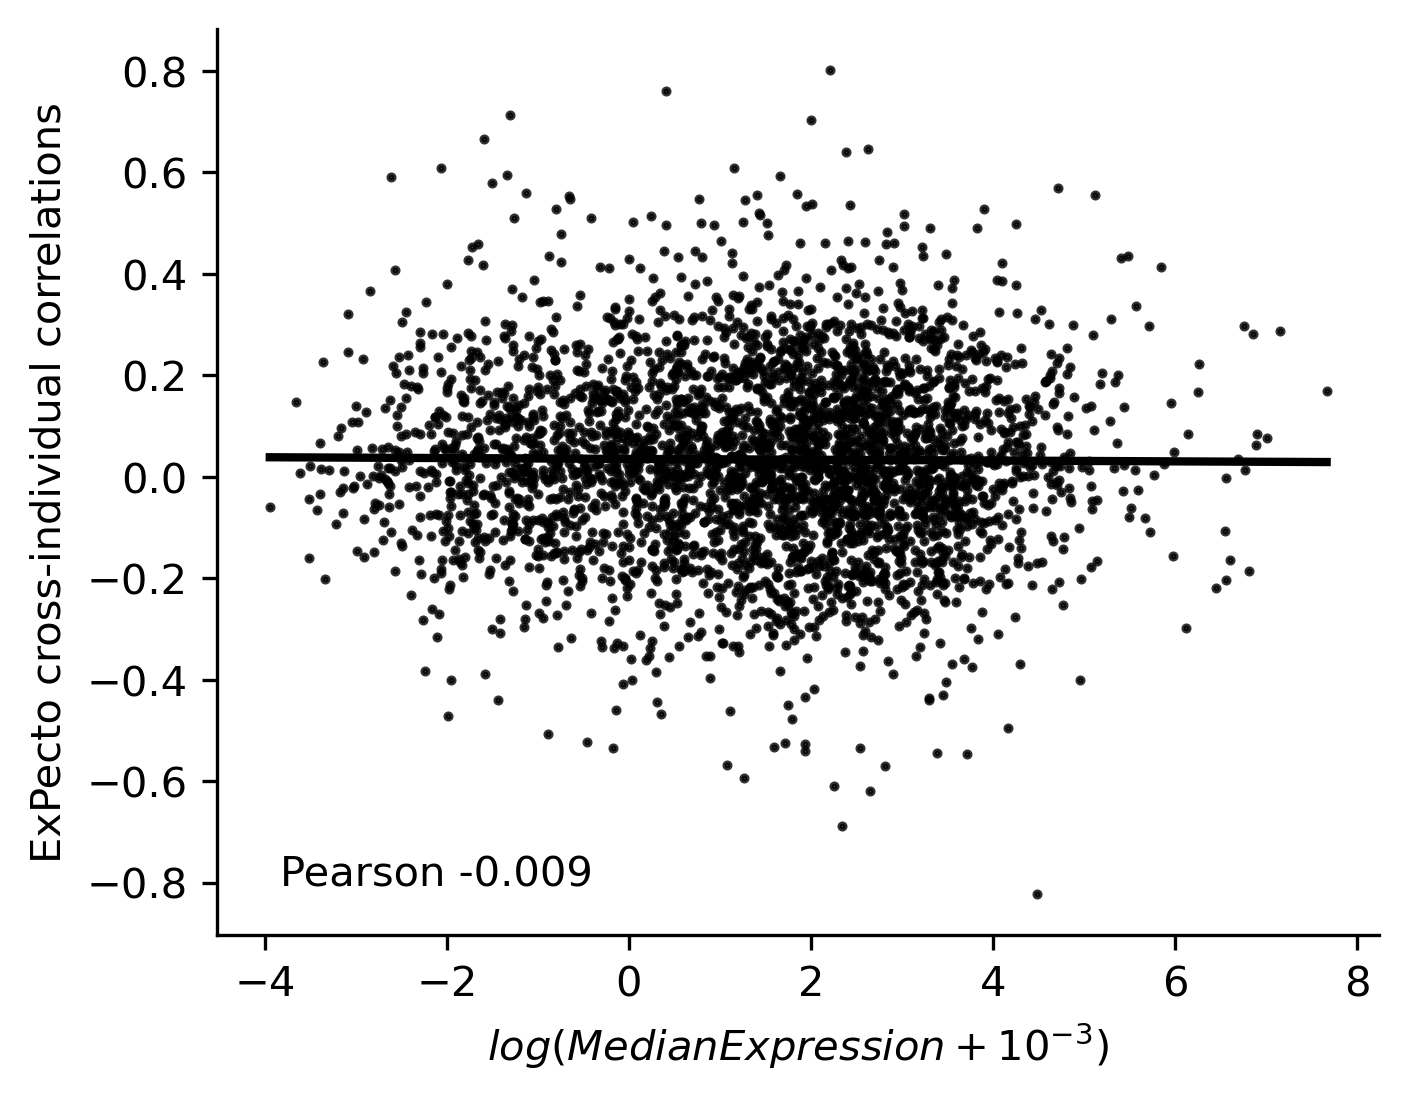

In [35]:
#  Extended Data Fig 9
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower()+"MedianExpression.pdf")
    compare_to_feat(corr_mapping[method_name],
                    xlabel=r"$log(MedianExpression + 10^{-3})$",
                    ylabel=f"{method_name} cross-individual correlations",
                    pdf=method_name.lower()+"MedianExpression.pdf")

enformerCoefVar.pdf


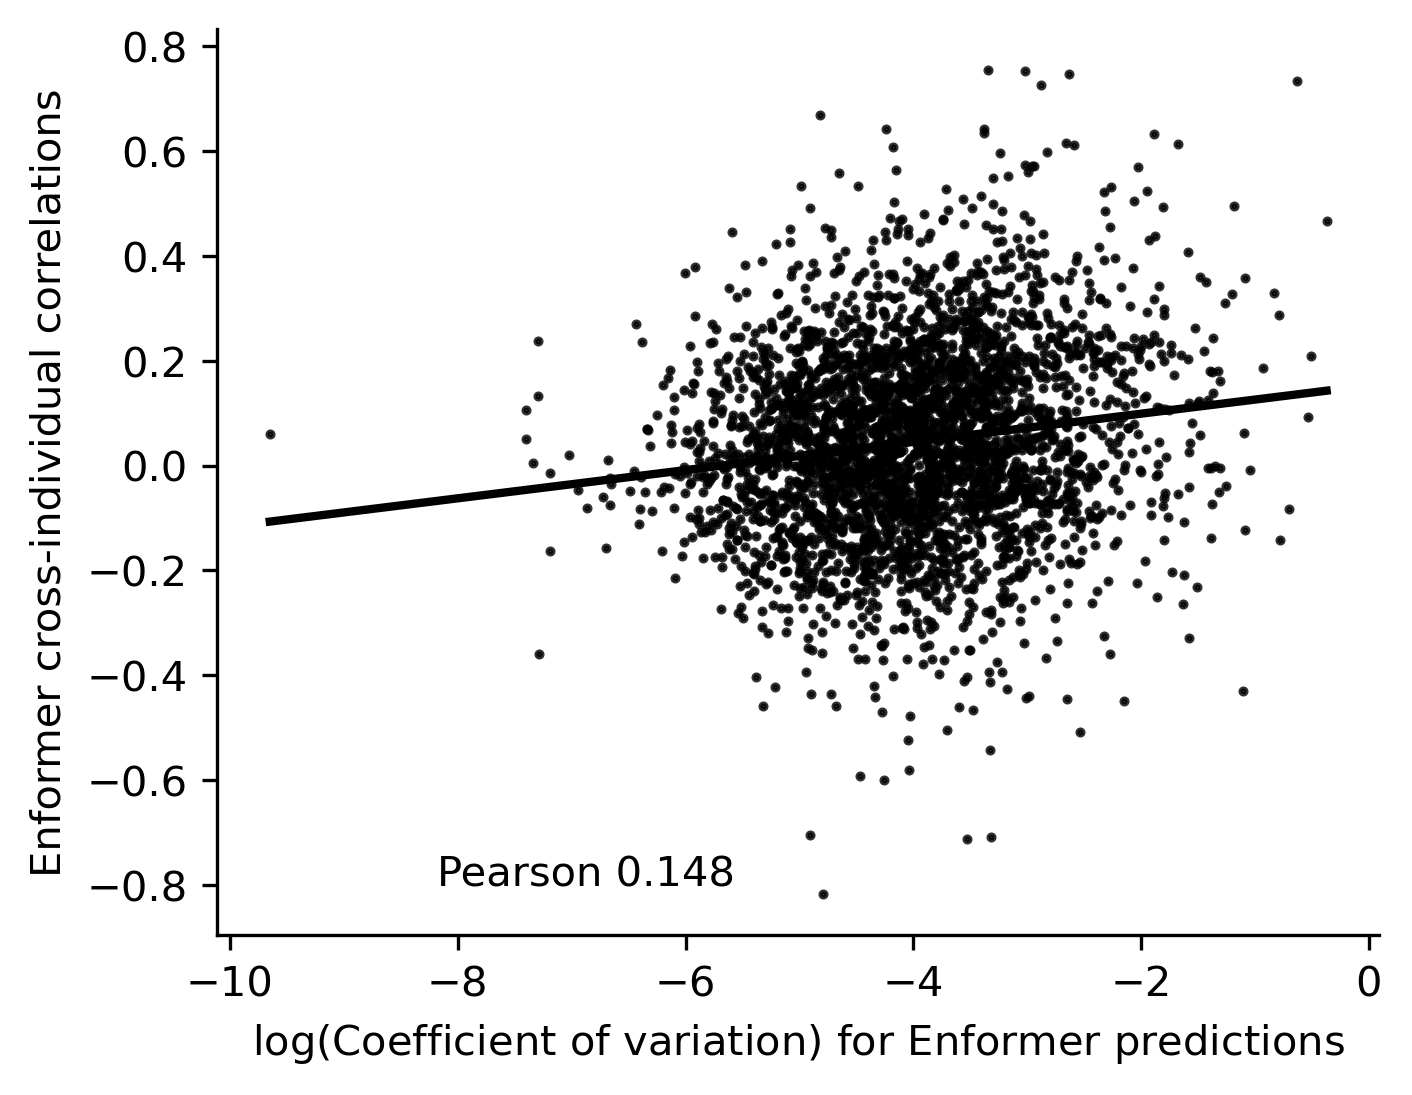

basenji2CoefVar.pdf


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in log


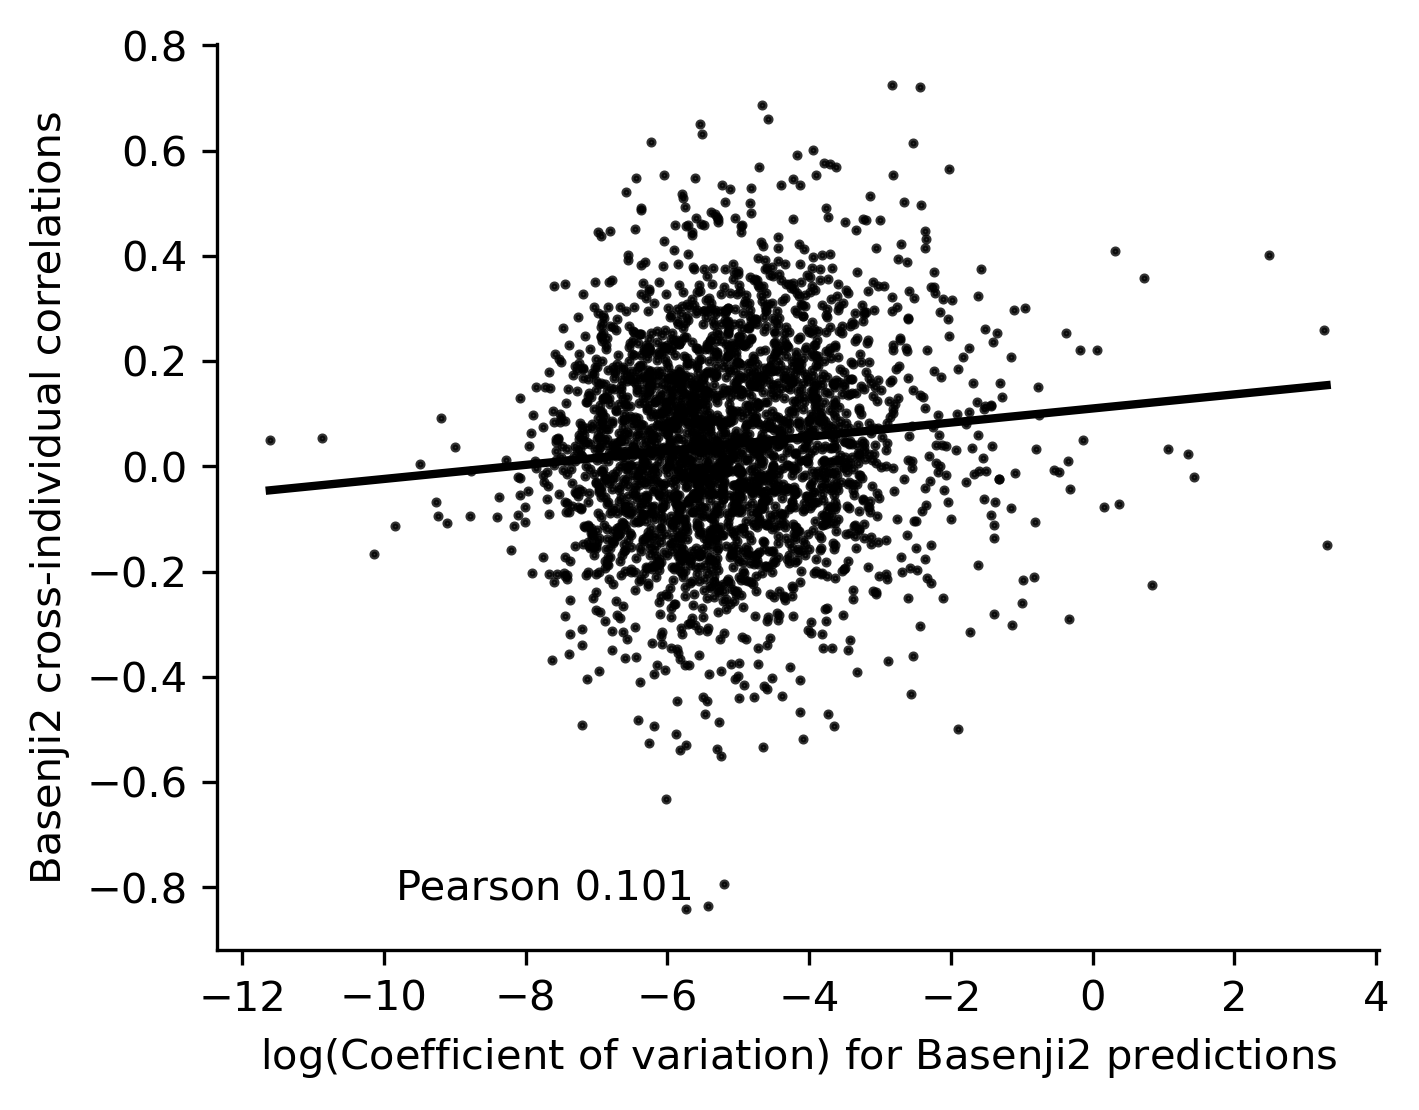

xpressoCoefVar.pdf


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in log


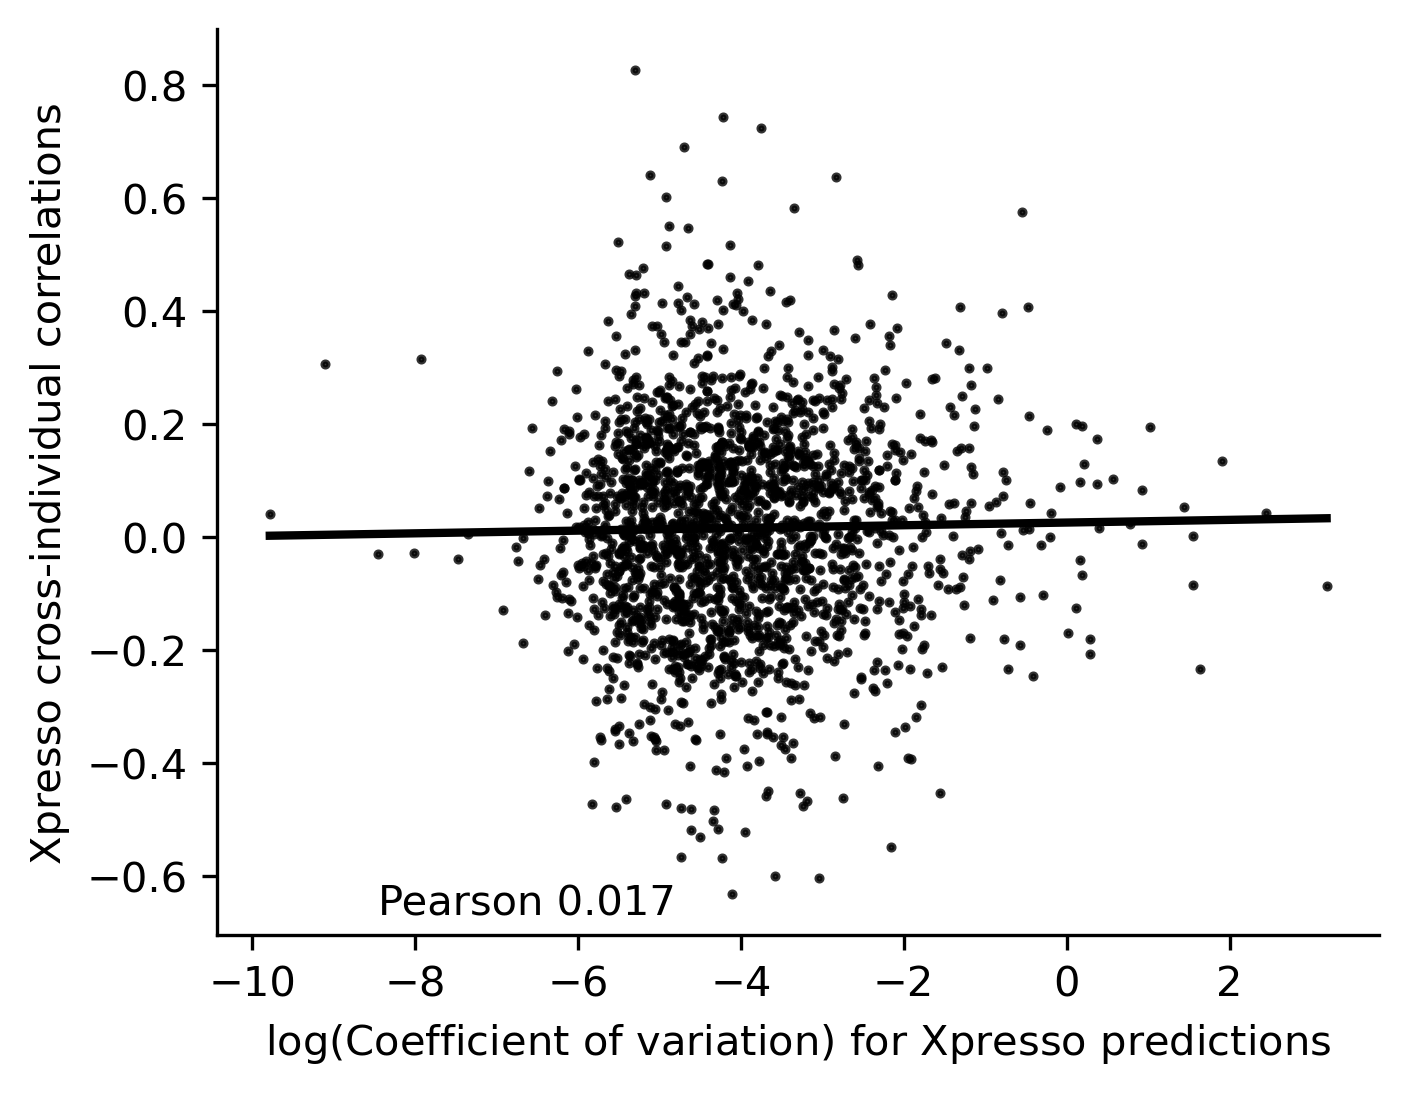

expectoCoefVar.pdf


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in log


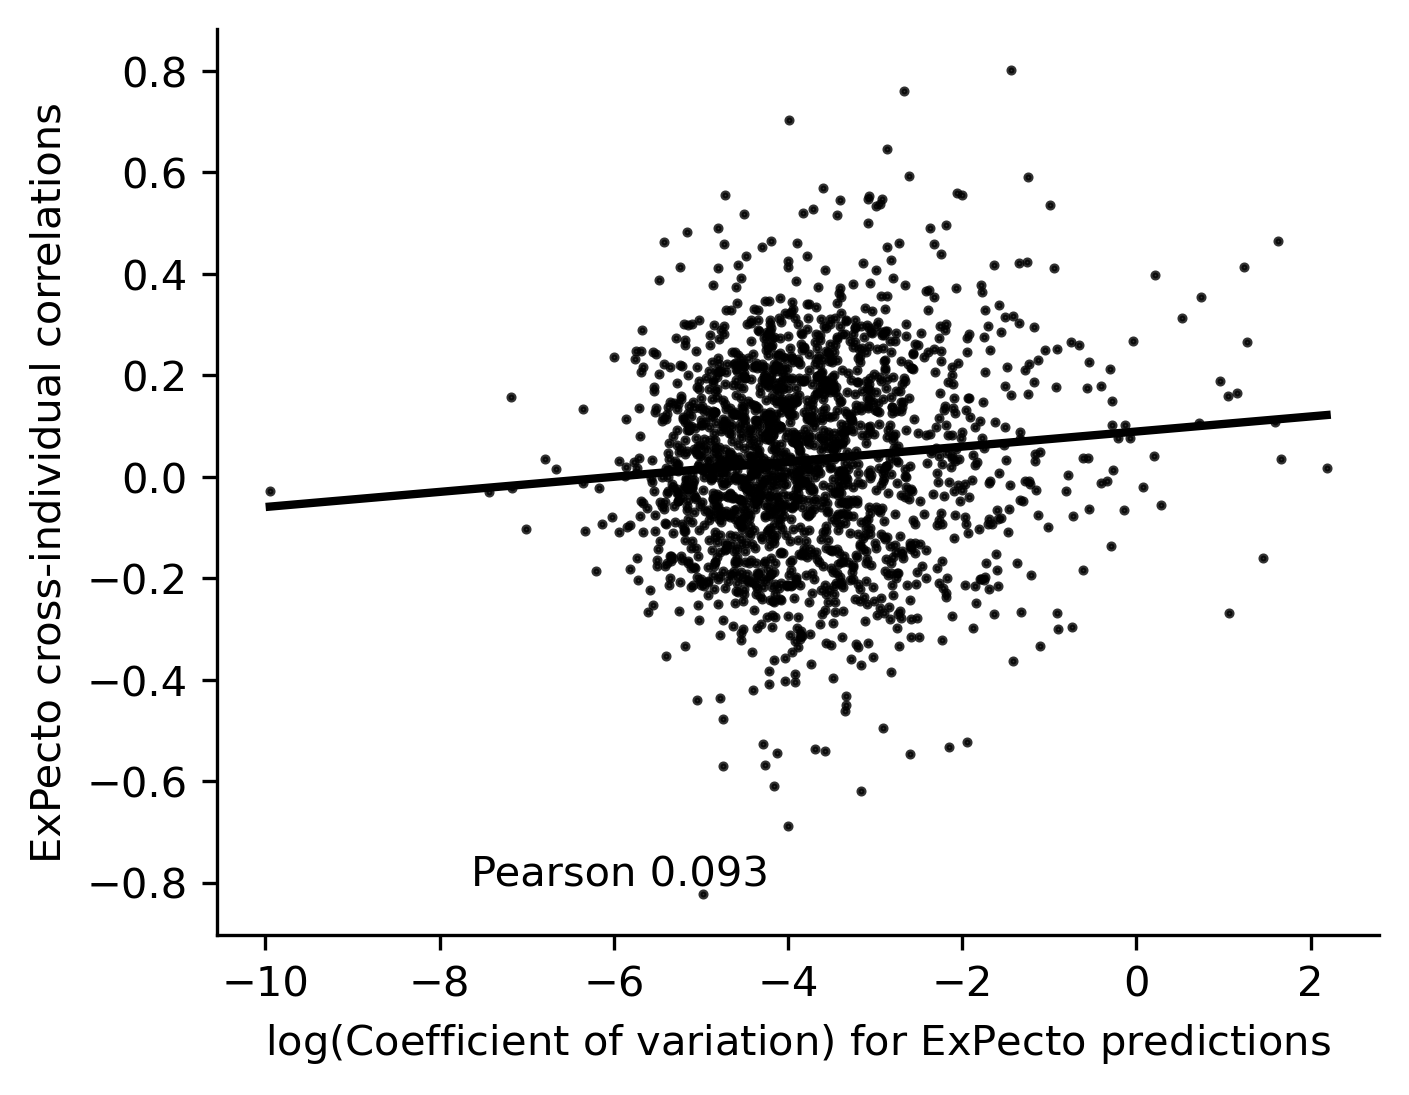

In [36]:
#  Figure 2C, Extended Data Fig 10
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower()+"CoefVar.pdf")
    compare_to_model_coefficient_of_variation(corr_mapping[method_name], path_mapping[method_name], 
                                              xlabel=r"$\log$(Coefficient of variation) for %s predictions" % method_name,
                                              ylabel=f"{method_name} cross-individual correlations",
                                              pdf=method_name.lower()+"CoefVar.pdf")

In [37]:
def fork_plot(corrs, x, y, x_label, y_label, pdf=""):
    plt.rcParams['figure.figsize'] = [5, 4]
    merged = corrs.merge(eqtl_df, on="name")
    merged["abseffsize"] = merged["rvalue"].abs()

    
    merged["logdistance"] = np.log(merged["distance"]+1)
    
    fig, ax = plt.subplots(dpi=300)
    toplim = np.max(merged[y])+0.1
    #plt.axhspan(0, toplim, facecolor='black', alpha=0.1)
    res = dv.regplot(data=merged[merged[y]>0], x=x, y=y, ci = 0,
                     line_kws={"c":bloodorange}, scatter_kws={"s":2, "c":"black"}, ax=ax)
    nona = merged[merged[y]>0][[x, y]].dropna()
    pearsonout = scipy.stats.pearsonr(nona[x], nona[y])
    text_left = 0.01*(np.max(merged[x])-np.min(merged[x]))+np.min(merged[x])
    plt.text(text_left, np.max(merged[y]), "Pearson %.3f" %  pearsonout[0], color=bloodorange)

    res = dv.regplot(data=merged[merged[y]<0], x=x, y=y, ci = 0,
                     line_kws={"c":turquoise}, scatter_kws={"s":2, "c":"dimgrey"}, ax=ax)
    nona = merged[merged[y]<0][[x, y]].dropna()
    pearsonout = scipy.stats.pearsonr(nona[x], nona[y])
    plt.text(text_left, np.min(merged[y]), "Pearson %.3f" %  pearsonout[0], color=turquoise2)

    #plt.ylim(-toplim, toplim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    
    if pdf!="":
        plt.savefig(f"figs/{pdf}", format="pdf")
    plt.show()

enformerEqtlPval.pdf


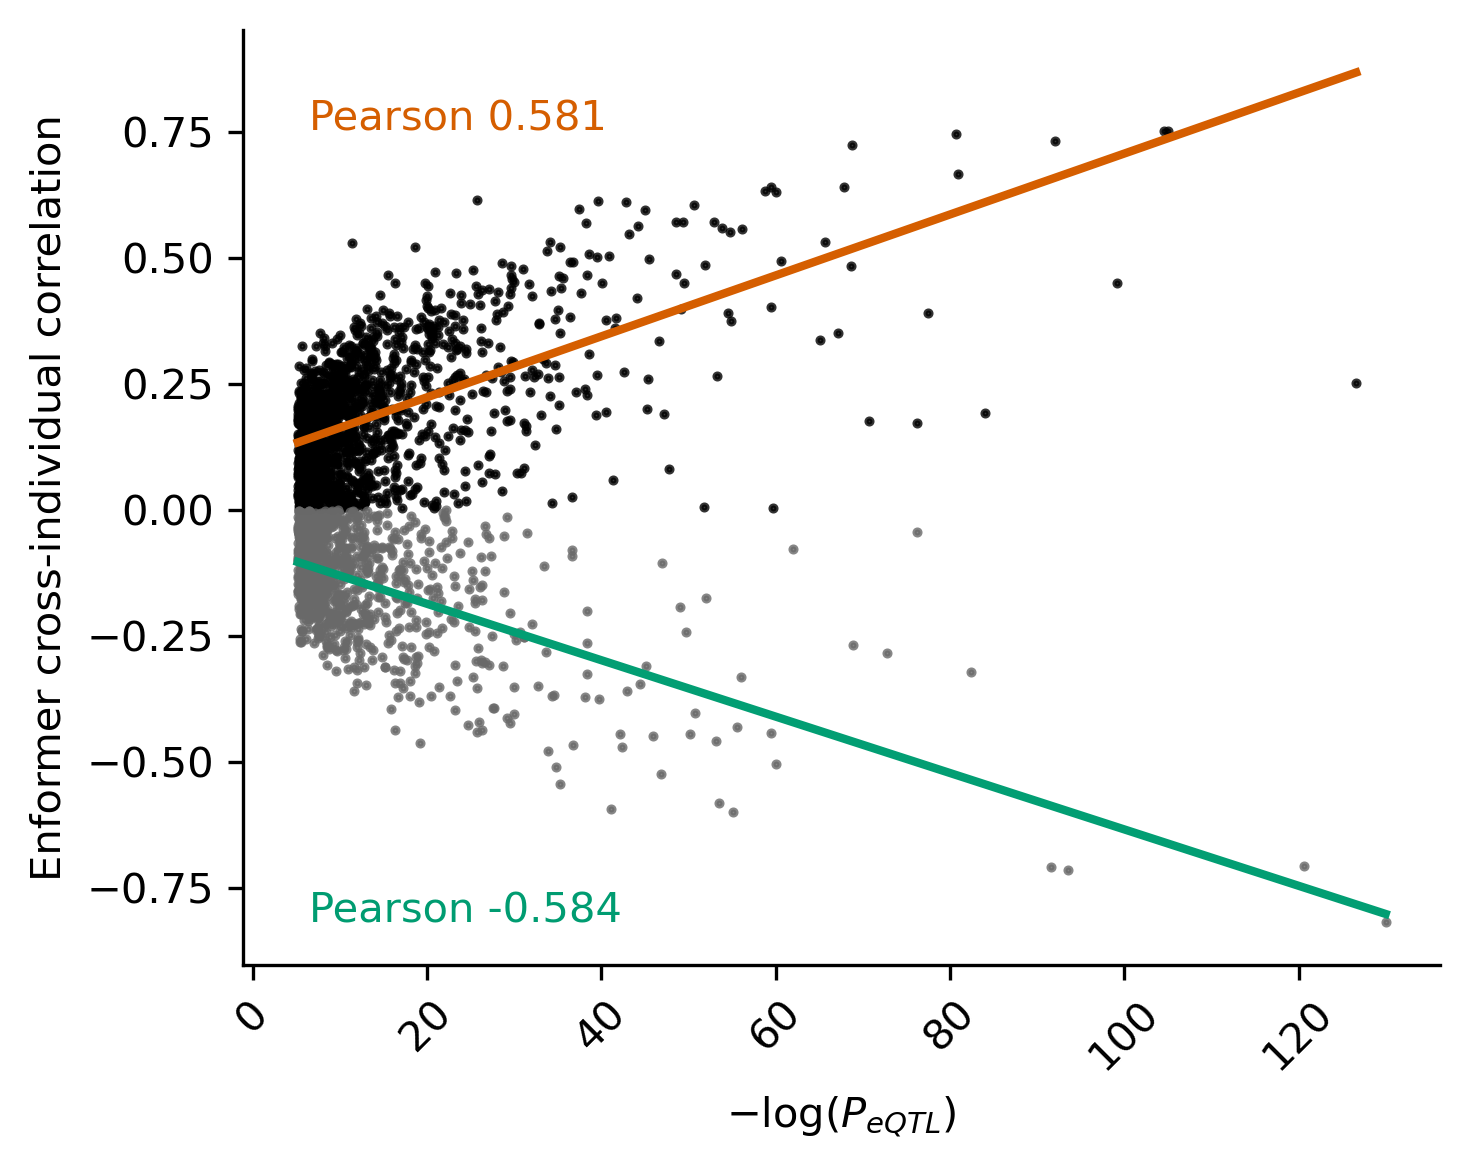

basenji2EqtlPval.pdf


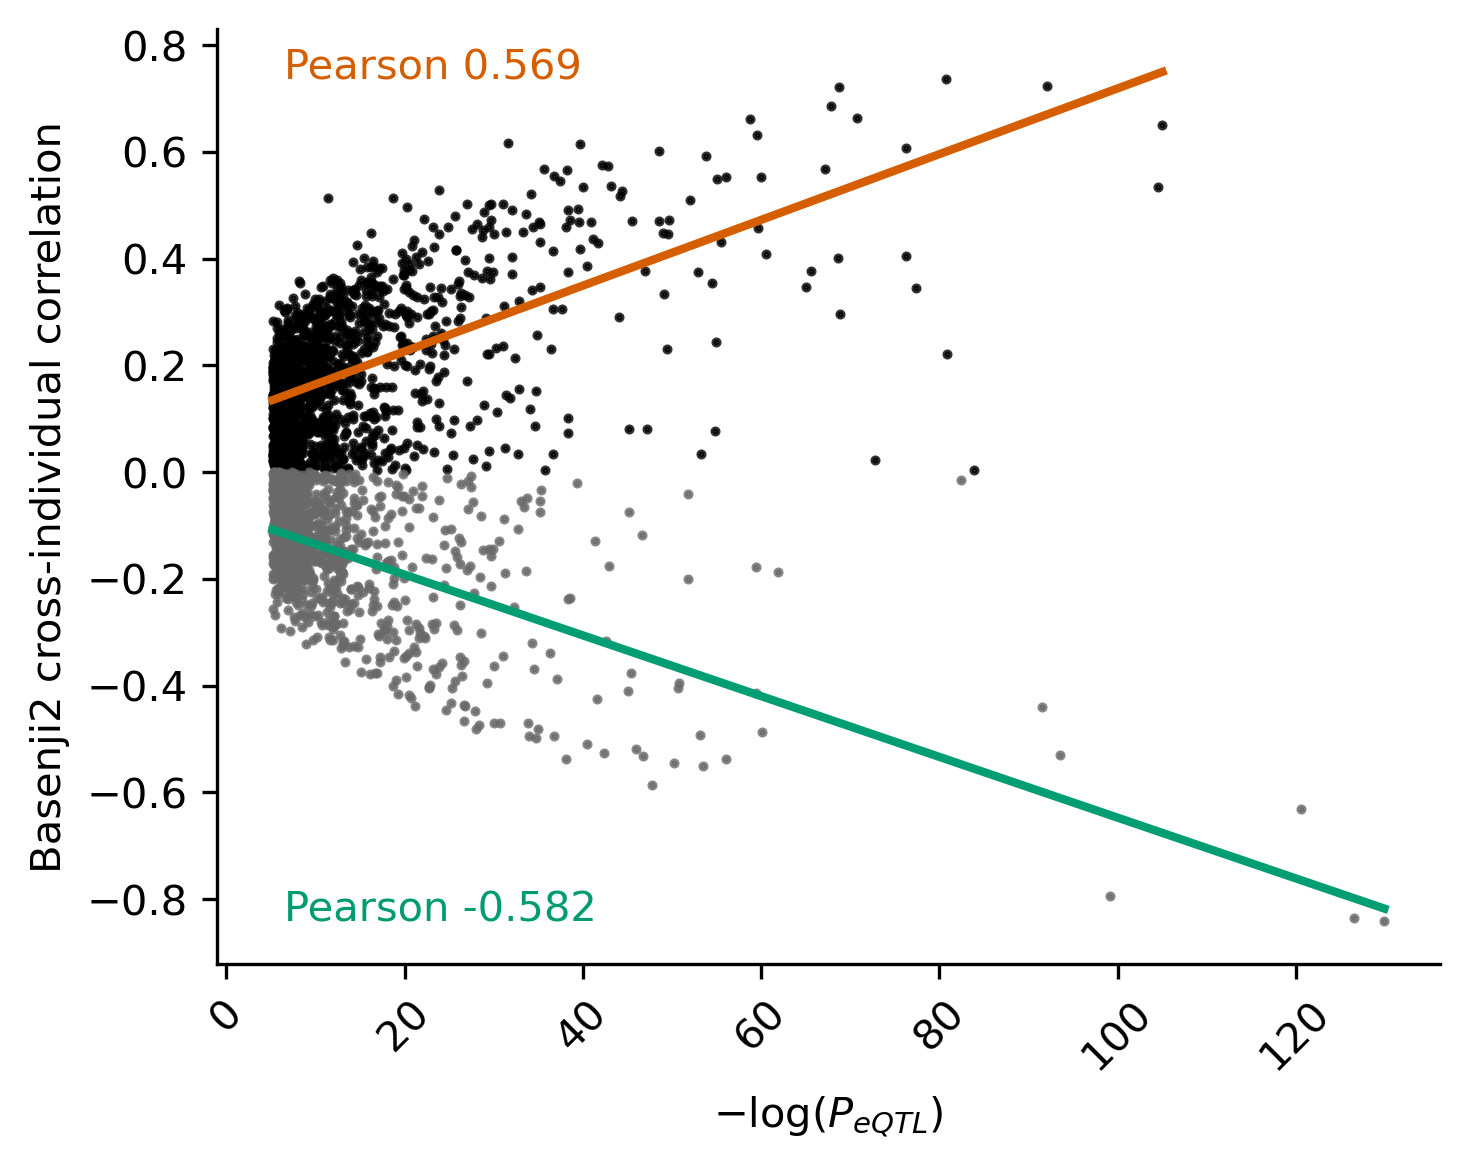

xpressoEqtlPval.pdf


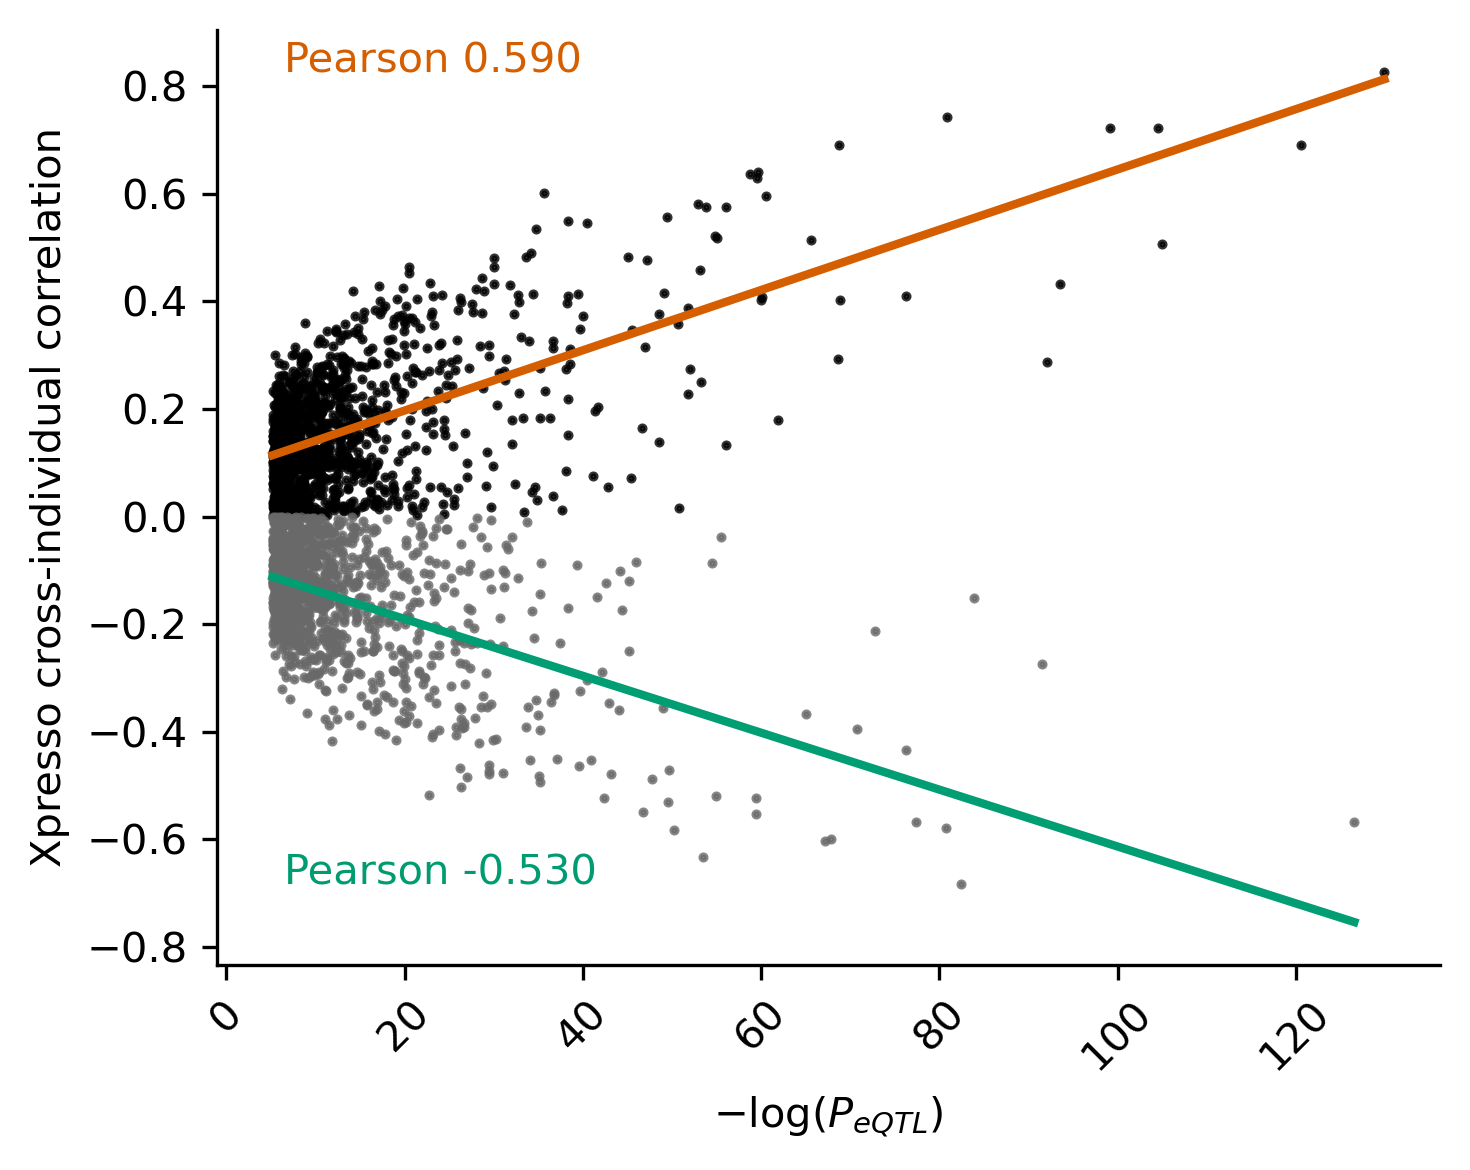

expectoEqtlPval.pdf


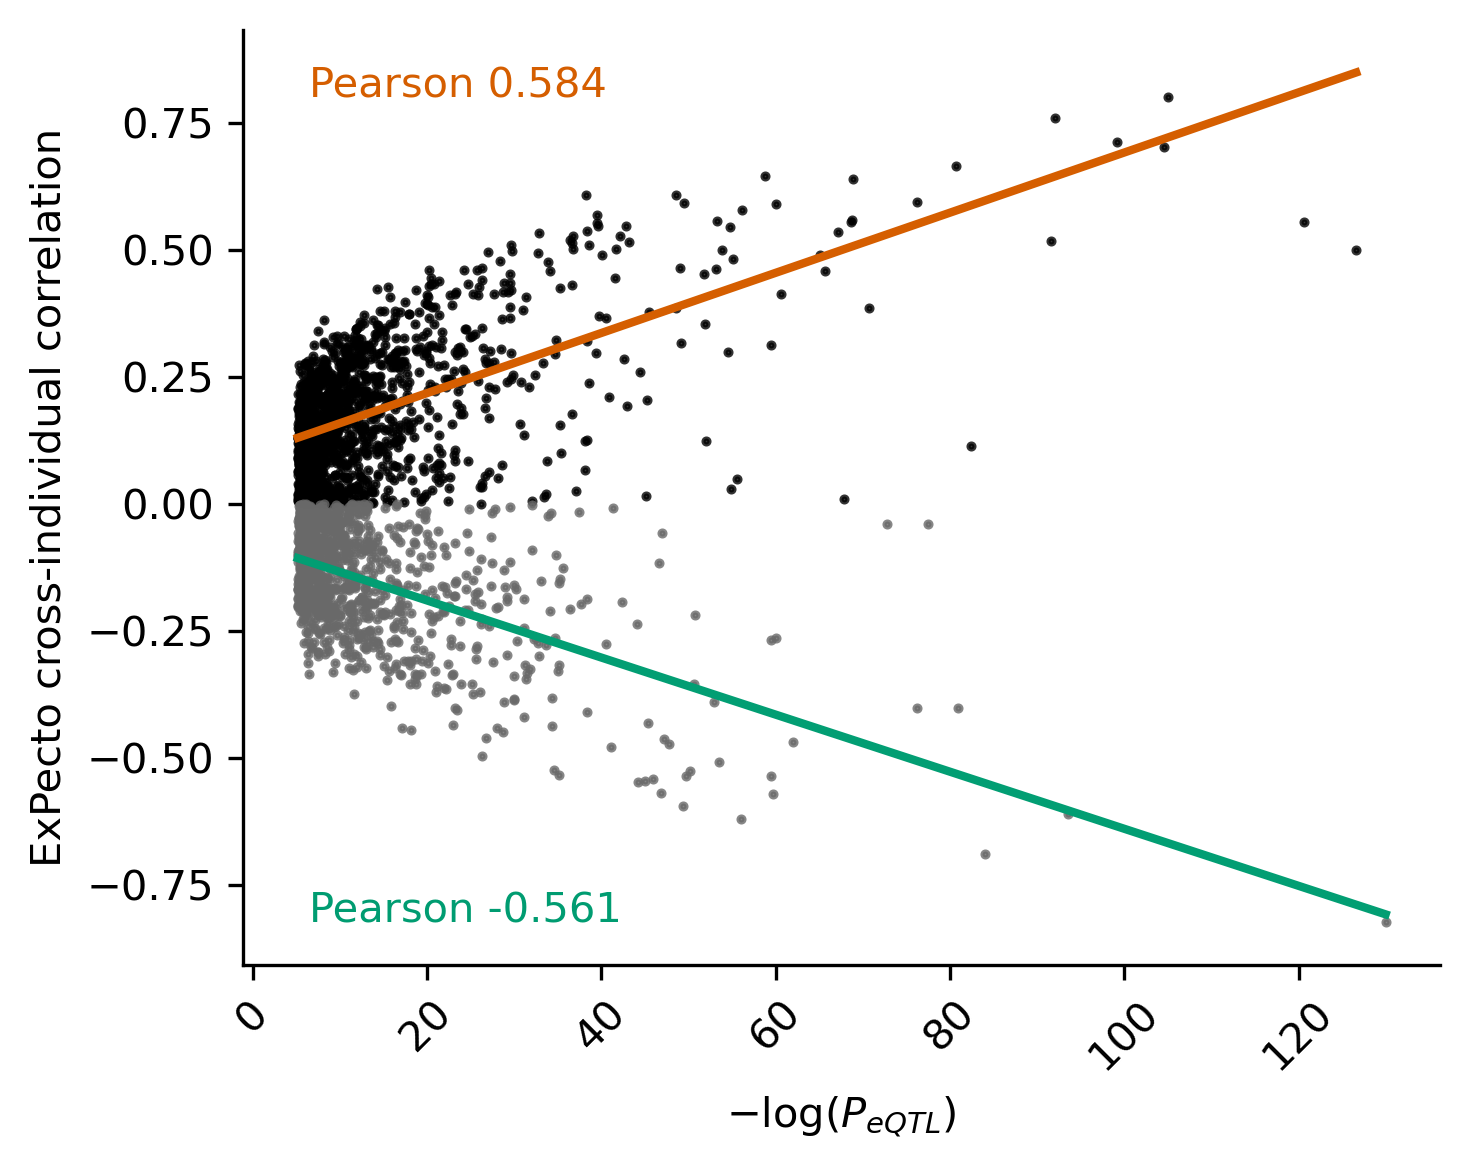

In [38]:
#  Figure 2C, Extended Data Fig 5
y = "spearman"
x = "log10pvalue"

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower()+"EqtlPval.pdf")
    
    fork_plot(corr_mapping[method_name], x, y, r'$-\log(P_{eQTL})$', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlPval.pdf")

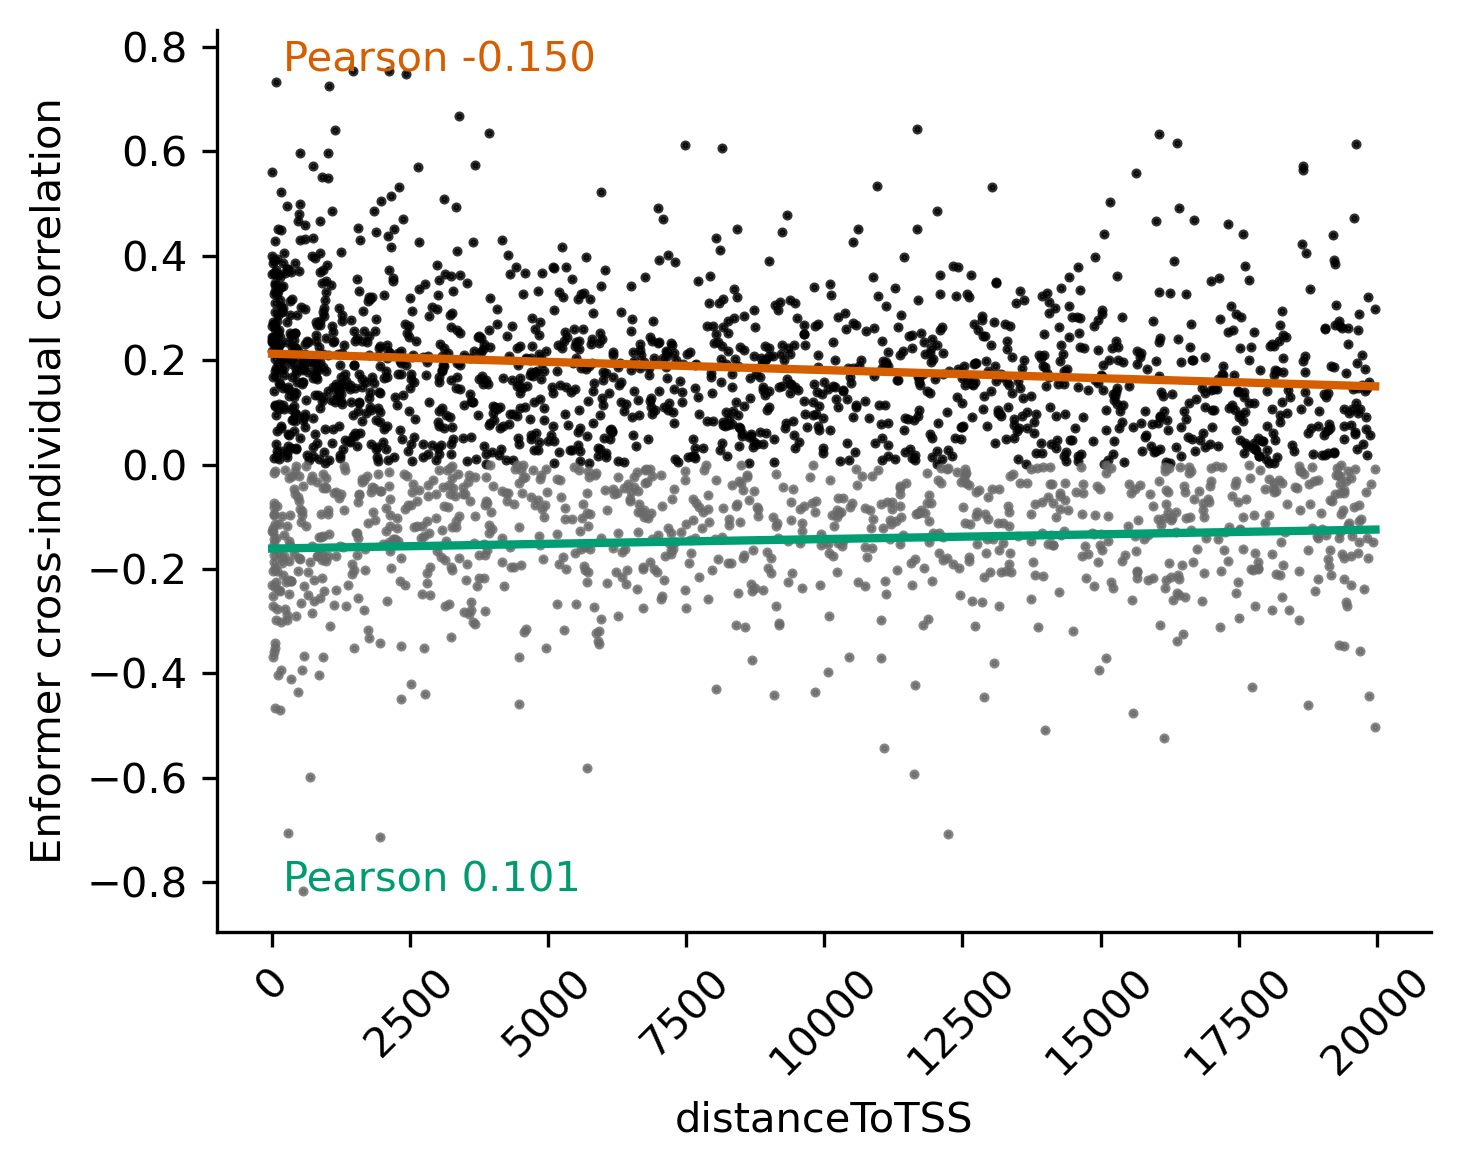

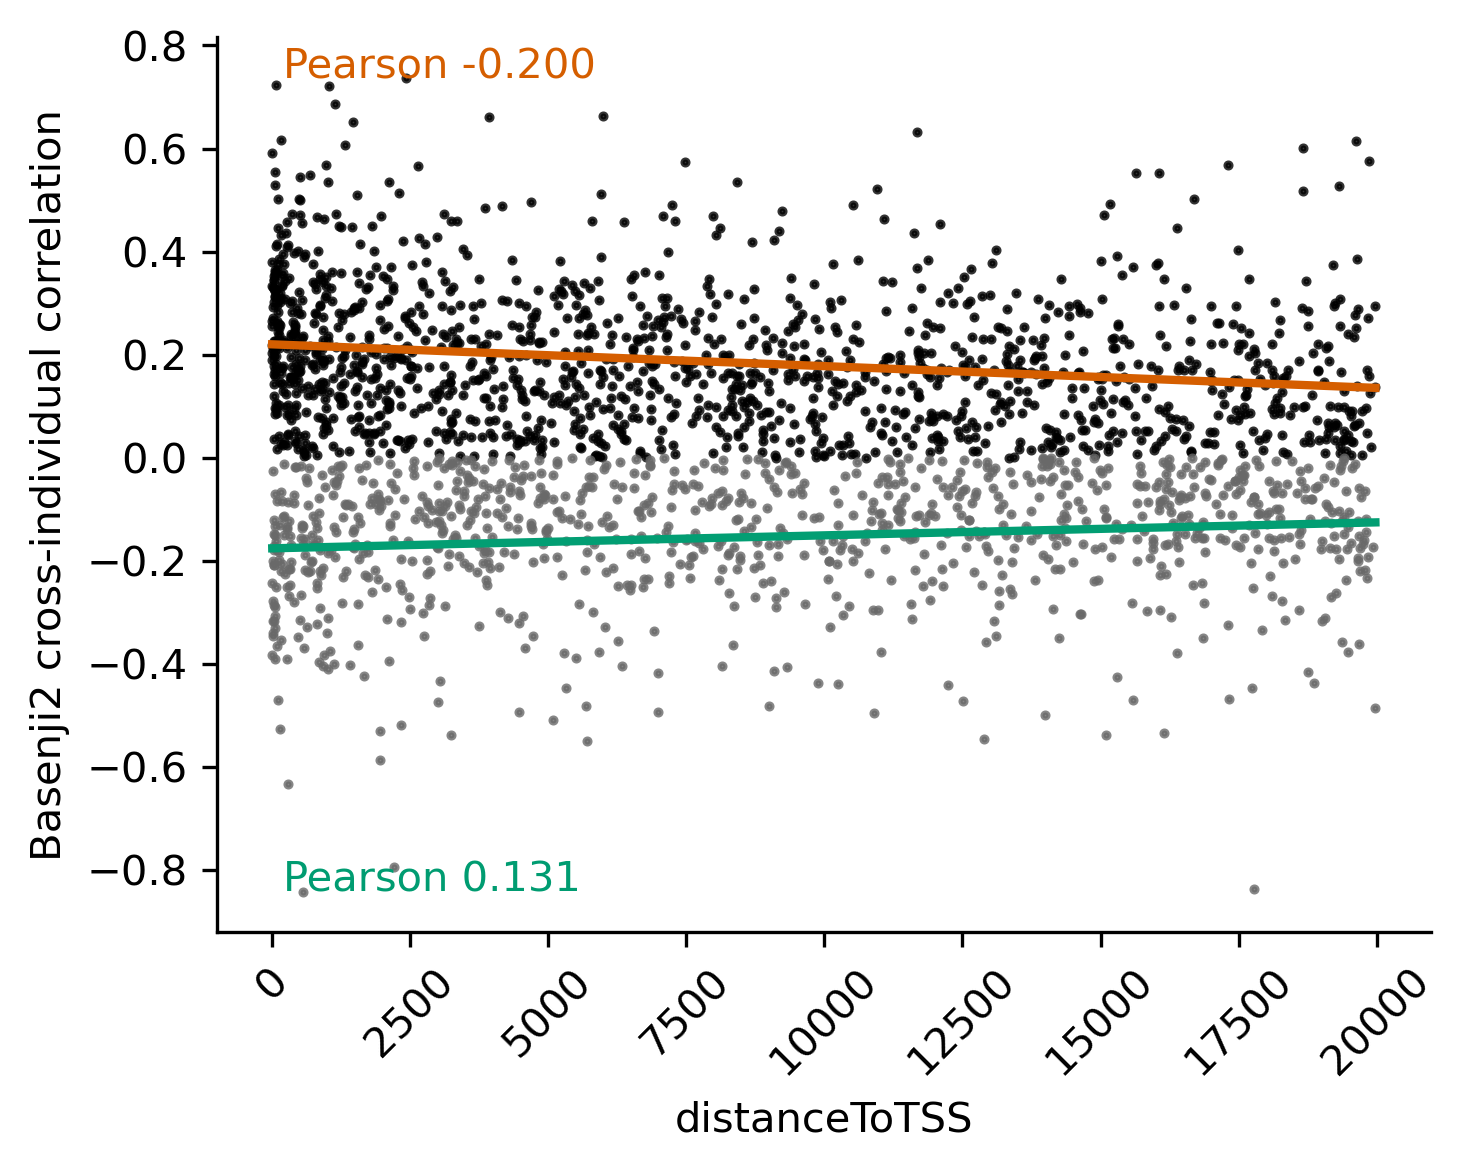

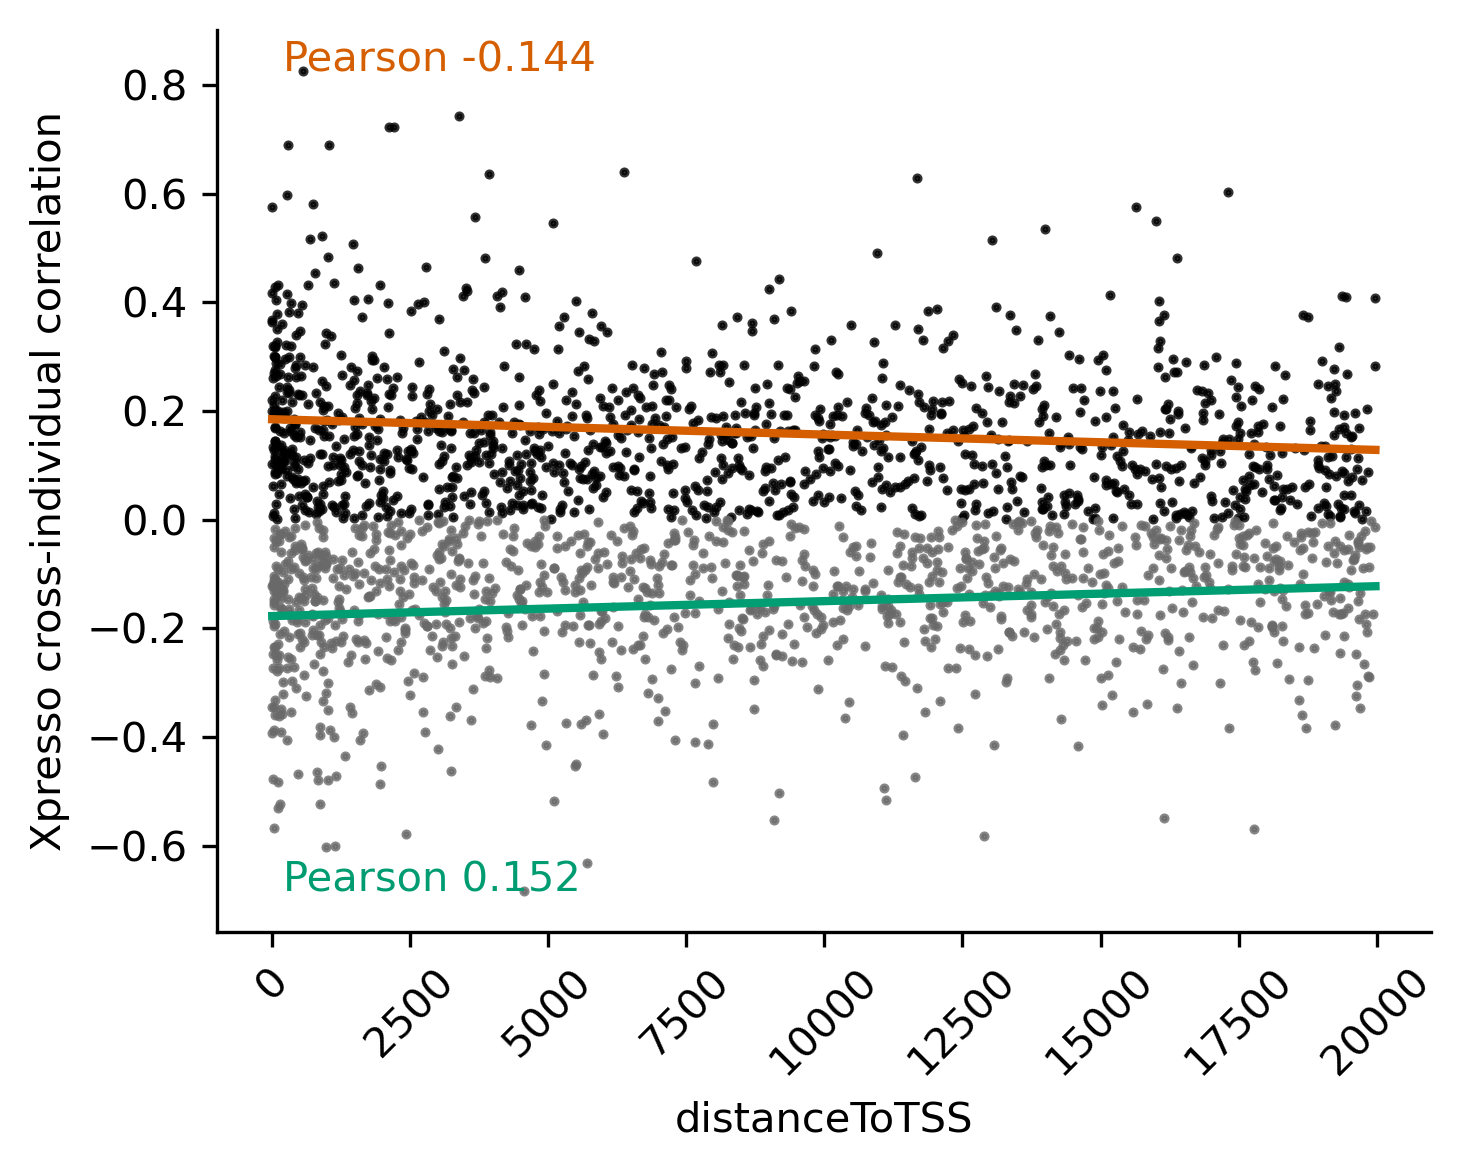

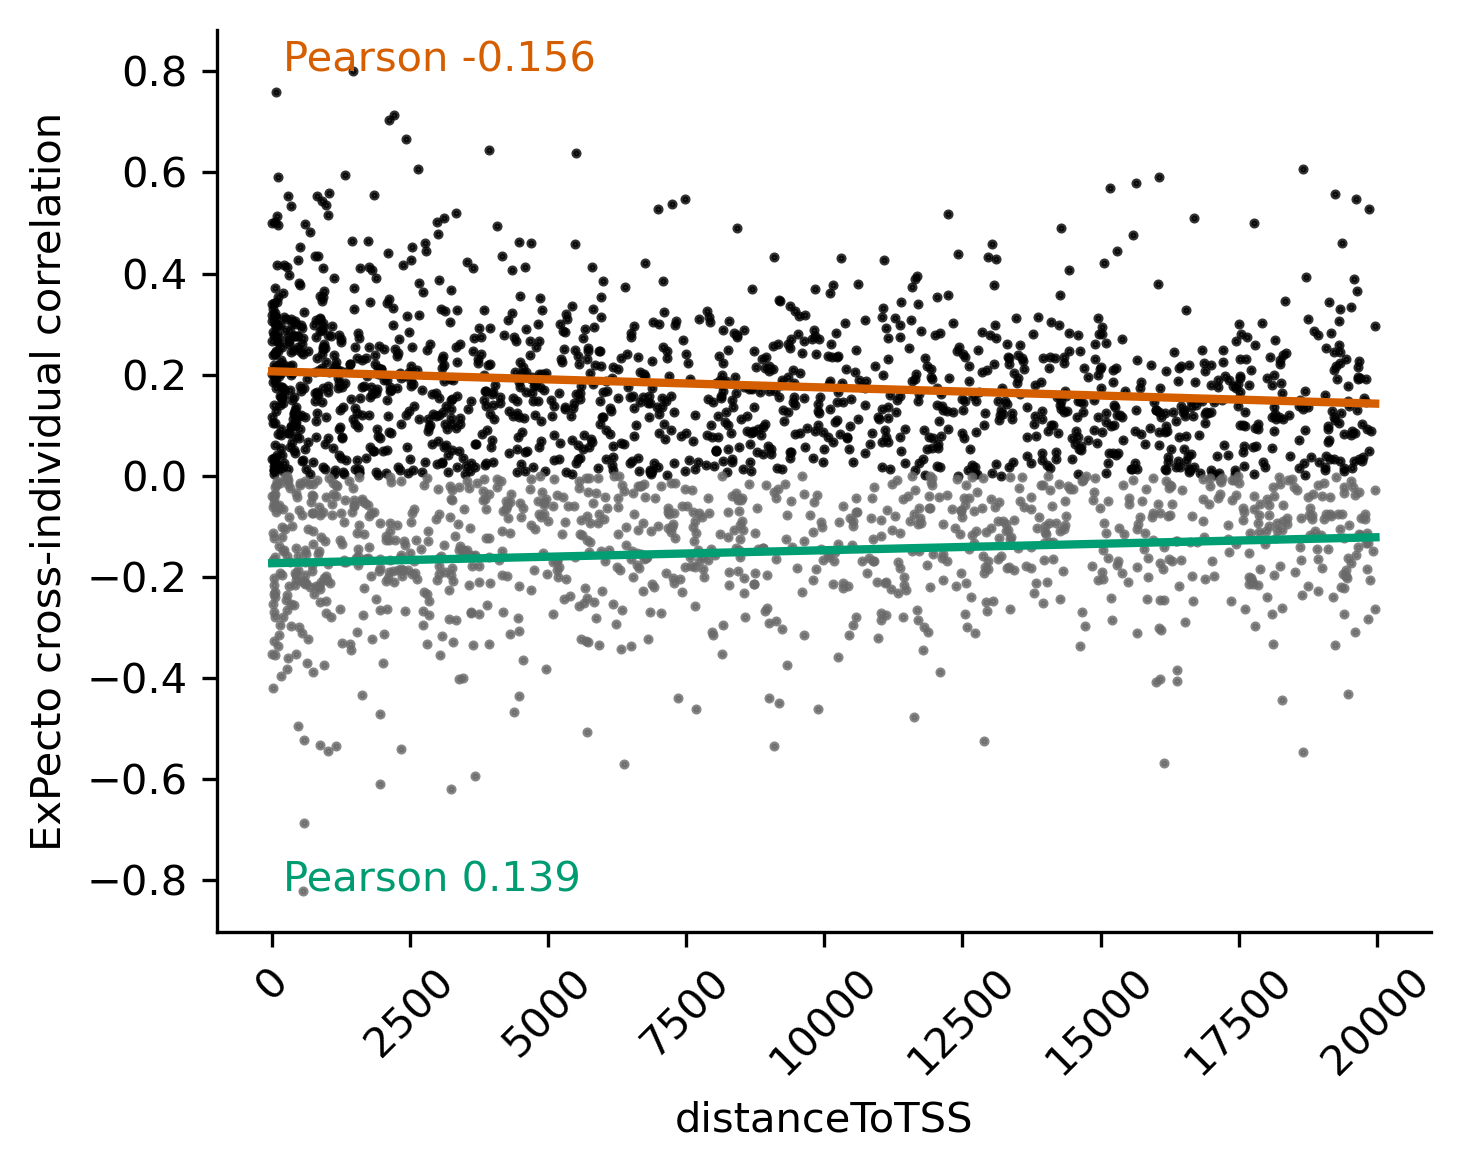

In [39]:
#  Figure 2C, Extended Data Fig 8
y = "spearman"
x = "distance"

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    fork_plot(corr_mapping[method_name], x, y, r'distanceToTSS', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlDistance.pdf")

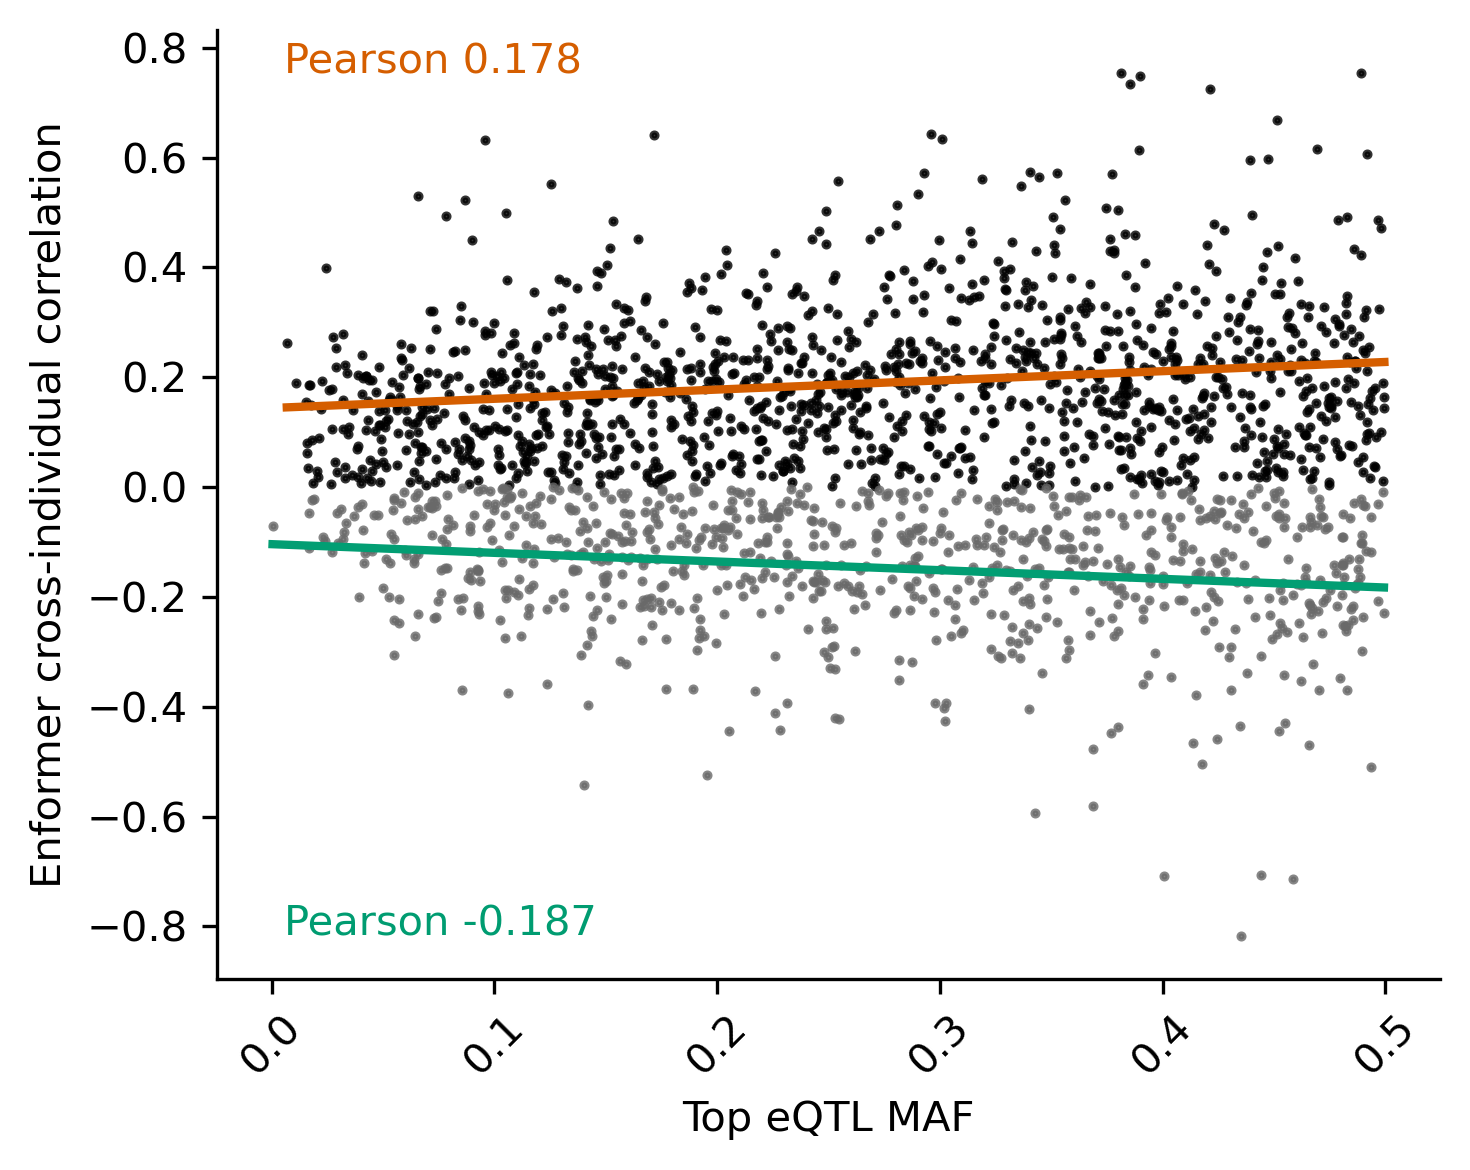

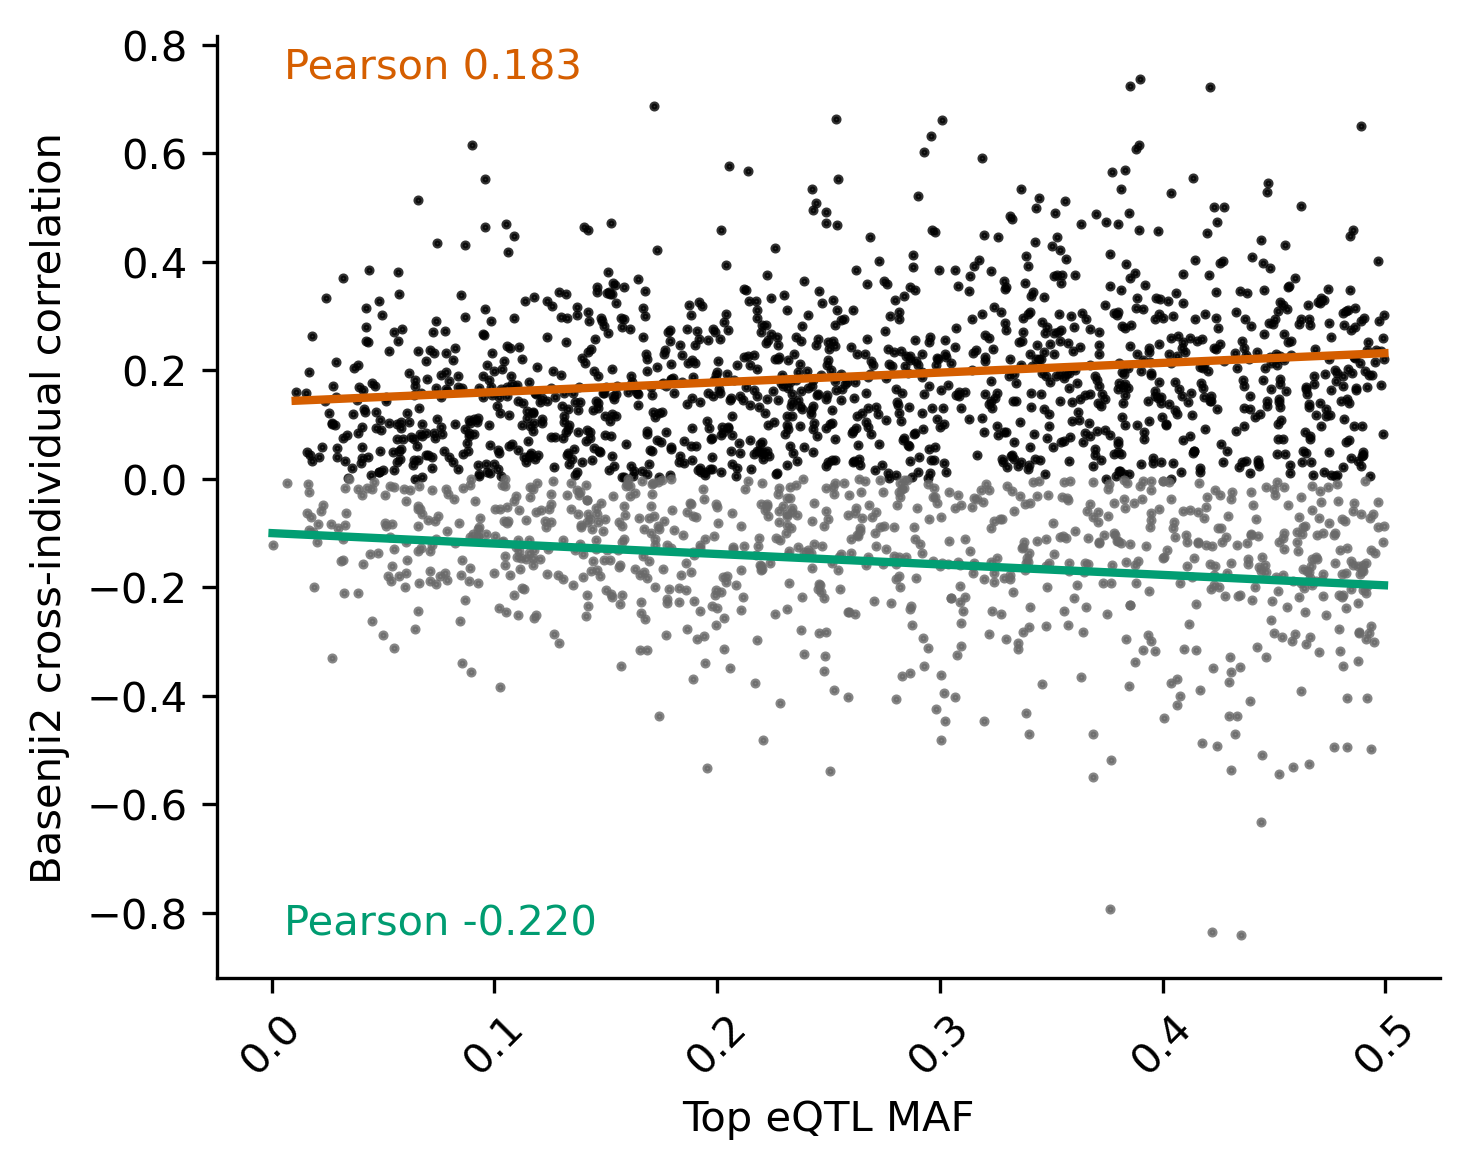

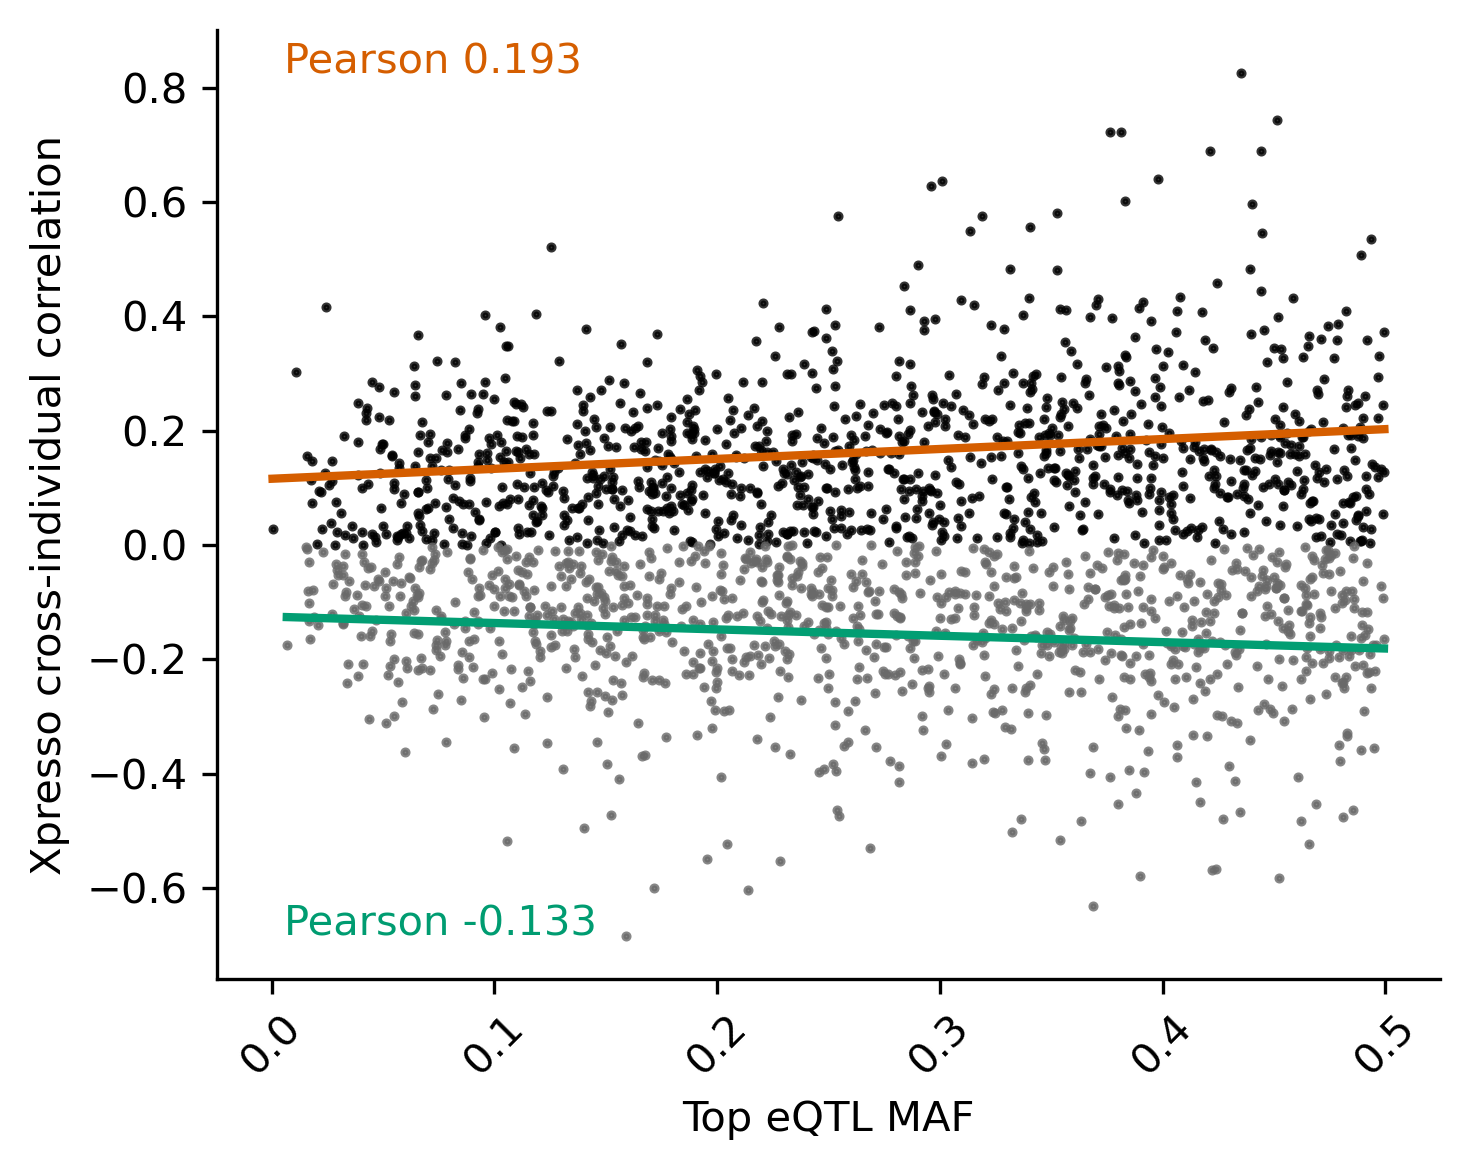

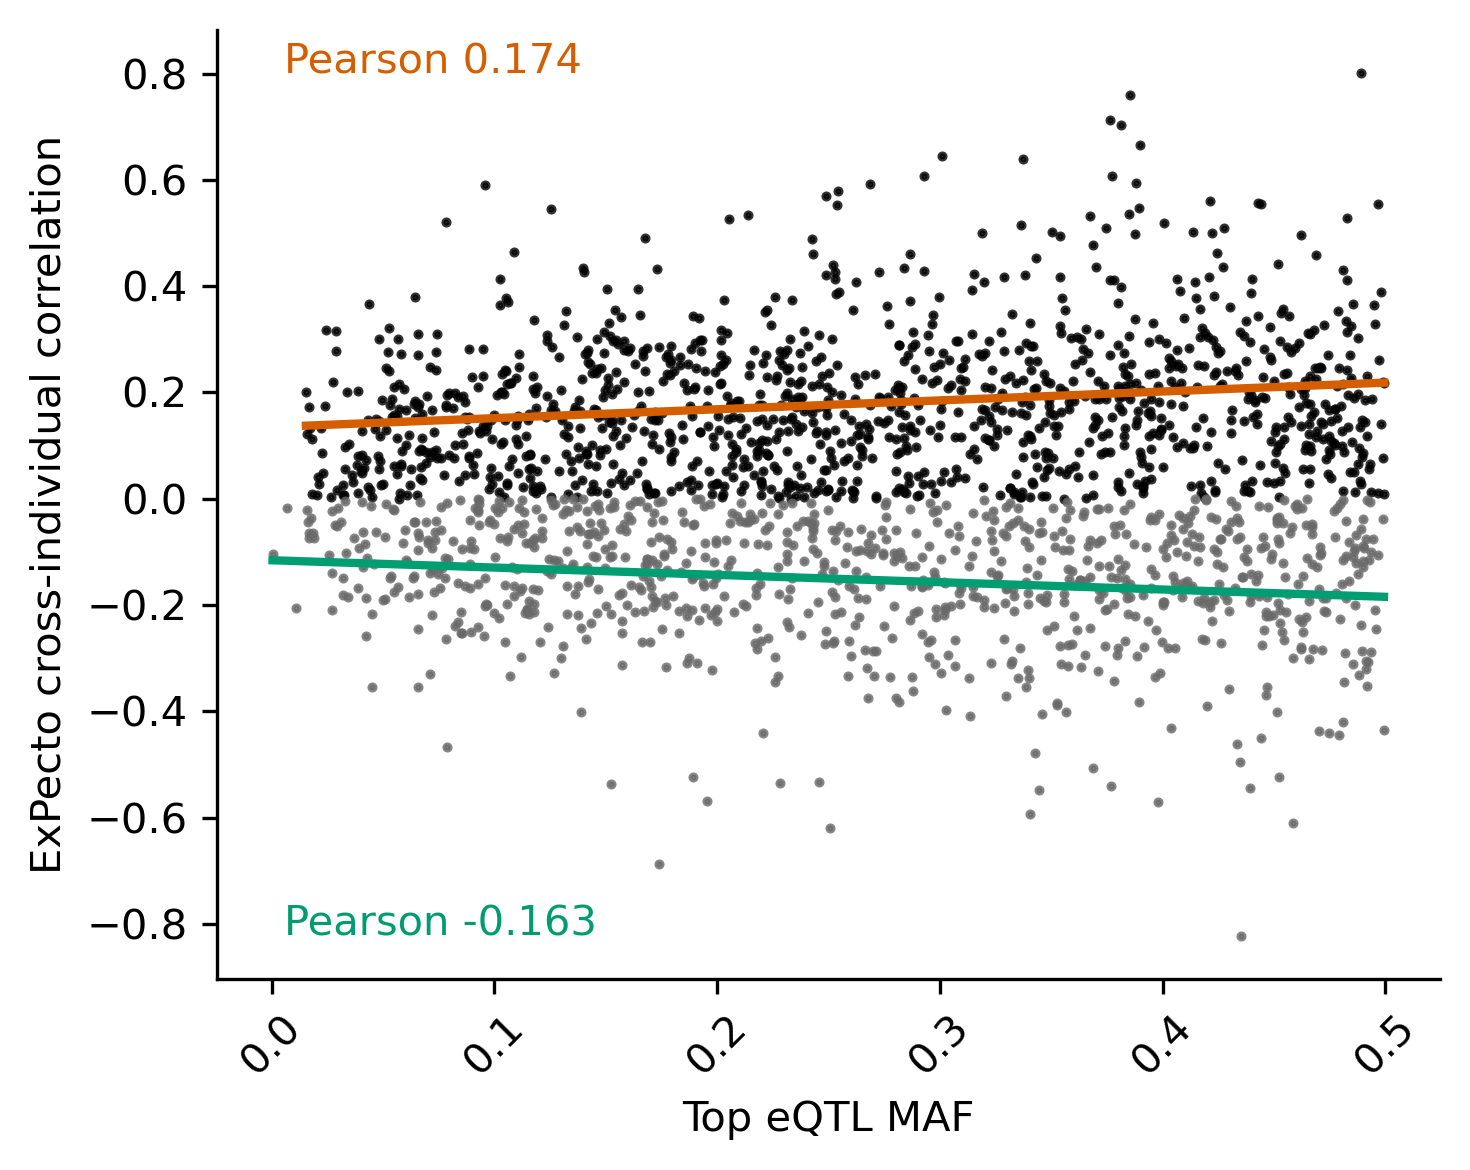

In [40]:
#  Extended Data Fig 7
y = "spearman"
x = "minor_allele_freq"

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    fork_plot(corr_mapping[method_name], x, y, 'Top eQTL MAF', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlAF.pdf")

enformerEqtlEffsize.pdf


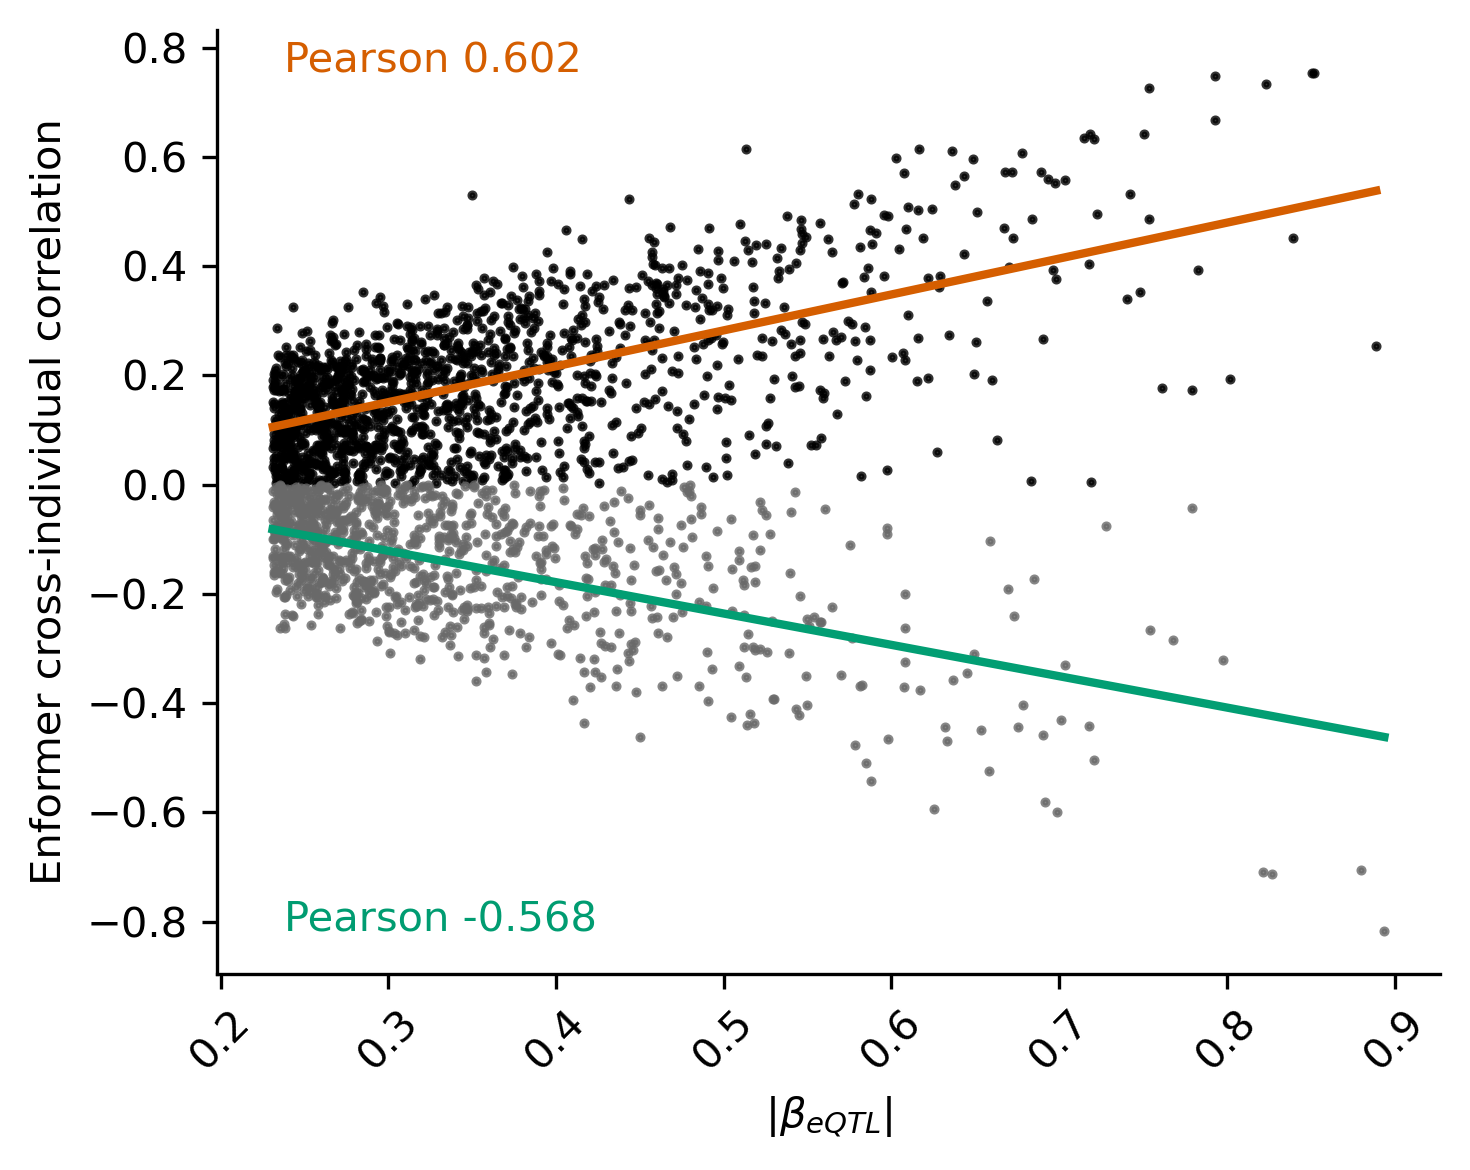

basenji2EqtlEffsize.pdf


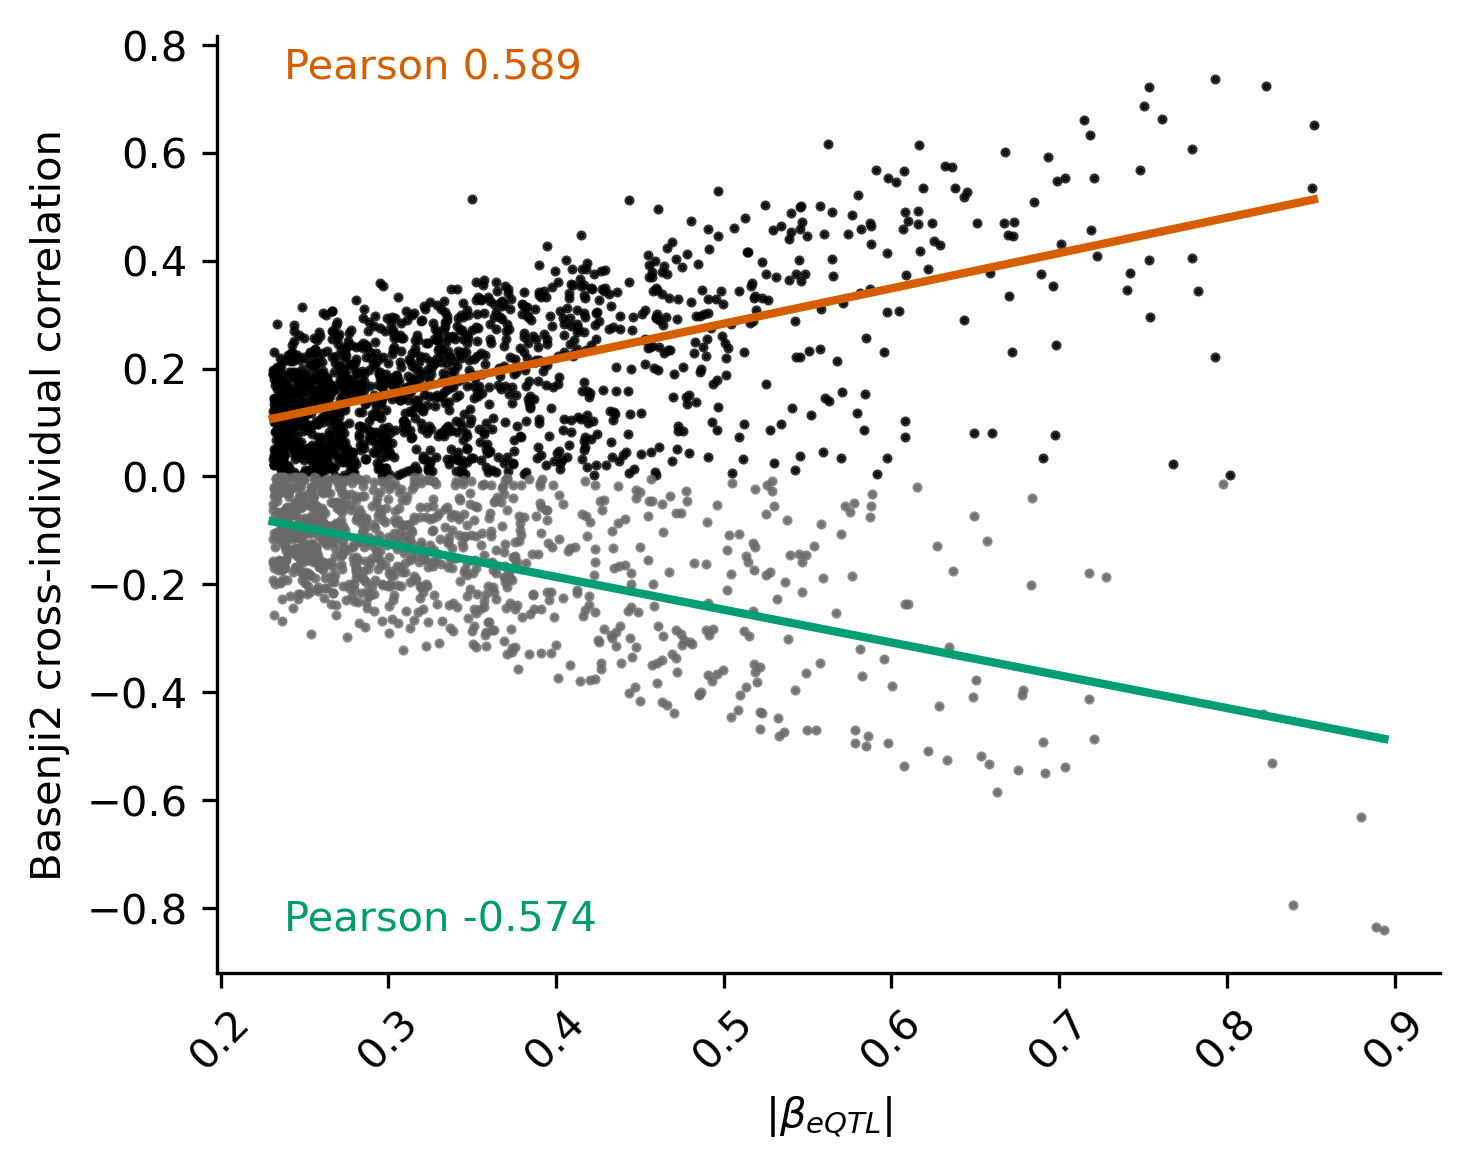

xpressoEqtlEffsize.pdf


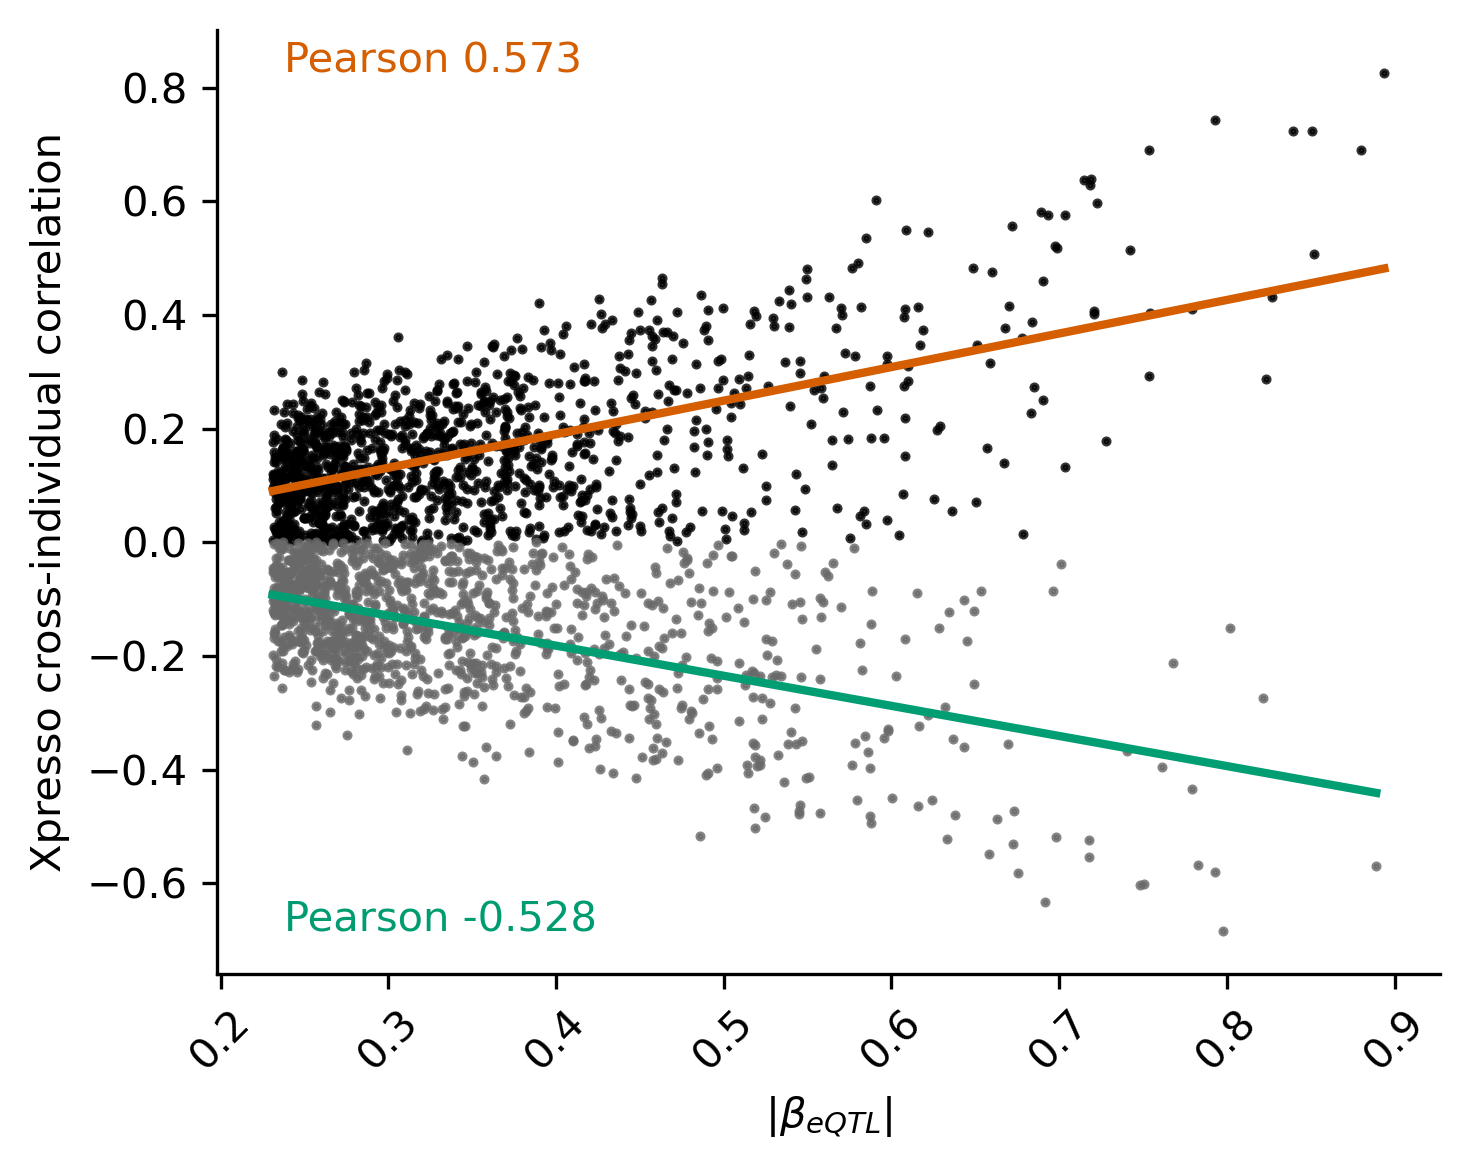

expectoEqtlEffsize.pdf


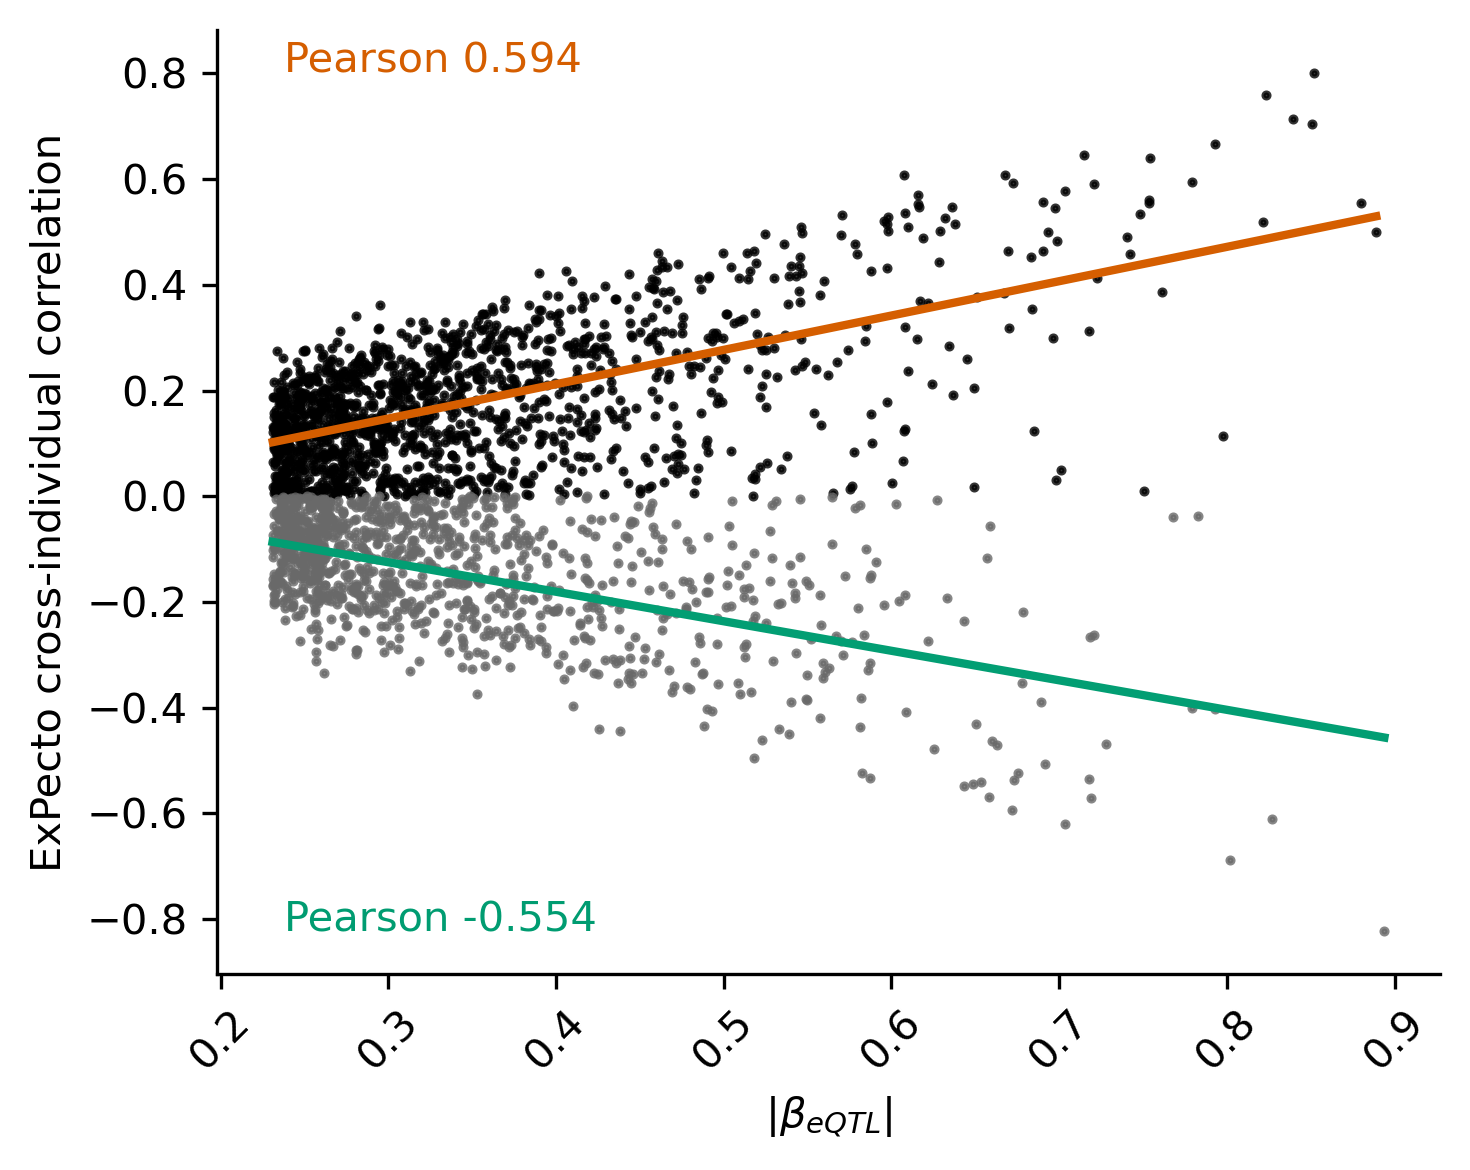

In [41]:
#  Extended Data Fig 6
y = "spearman"
x = "abseffsize"
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower()+"EqtlEffsize.pdf")

    fork_plot(corr_mapping[method_name], x, y, r'$|\beta_{eQTL}$|', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlEffsize.pdf")